# Chapter 4: Vibrational Motion
Prof. Eugene DePrince, Florida State University, and Prof. Jay Foley, UNC Charlotte

In the previous notebook, we discussed quantum mechanical problems involving translational motion: the free-particle, the particle-in-a-box model, the finite square well potential model, and tunneling through a one-dimensional potential energy barrier. In this notebook, we continue exploring model problems, with a focus, this time, on vibrational motion. In particular, we will find analytic solutions the Schrödinger equation for the (one-dimensional) quantum harmonic oscillator model, which captures the main qualitative features of vibrational motion in molecular systems. 

## The Harmonic Potential

A harmonic oscillator is a system that, when displaced from its equilibrium position, experiences a harmonic restoring force, which is proportional to the displacement. In one dimension, this force would be

$$ \begin{align}
F_x = -k (x - x_e)
\end{align}$$

where $x - x_e$ is the displacement from the equilibrium position, $x_e$, and $k$ is the proportionality constant, which is called the force constant. Recall that force and potential are related by

$$ \begin{align}
F_x = -\frac{d }{dx}V(x) = -k ( x - x_e)
\end{align}$$

Integrating this expression yields the potential

$$ \begin{align}
V(x) = \frac{1}{2} k (x - x_e)^2 + c
\end{align}$$

where $c$ is an arbitrary additive constant. This constant will not affect the solutions to the classical or quantum harmonic oscillator problems, but it will provide an arbitrary shift to the associated energies. For convenience, we choose $c = 0$, and we proceed with the potential

$$ \begin{align}
V(x) = \frac{1}{2} k (x - x_e)^2
\end{align}$$

Because the harmonic oscillator problem is a model for molecular vibrations, it will be illustrative to consider how this potential relates to one for an actual molecular system. We will consider the diatomic carbon monoxide, CO. Below, we will calculate the potential energy curve along the bond stretch coordinate for CO using a procedures for finding approximate solutions to the electronic part of the Schrödinger equation, called Hartree-Fock theory. You can read more about Hartree-Fock theory in [this notebook](https://deprincelab.github.io/tutorials/jupyter_notebooks/hartree_fock/hartree_fock.html). We will use this approach in the [PySCF](https://pyscf.org/) electronic structure package, with the cc-pVDZ basis set.

The first code block will install the relevant packages for all of the PySCF calculations performed in this notebook if needed.

 - If you are running on Google Colab, you should run these every time you run this notebook 
 - If you are running locally, you can run these commands locally only once and then you will have them for all future sessions.
   
`!pip install pyscf`

`!pip install geometric`

`!pip install pyberny`


In [1]:
!pip install pyscf
!pip install geometric
!pip install pyberny

The next block imports the relevant libraries from PySCF

In [2]:

import numpy as np
from pyscf import gto, scf # Import necessary modules

In [3]:
# conversion from Angstroms to atomic units
ang_to_au = 1.88973

# set molecule
mol_template = """
C 0 0 0
O {} 0 0
"""

hf_potential = []


dx = 0.01
dx_au = dx * ang_to_au

# array of bond lengths in angstroms, which will be what PySCF understands
x = np.arange(0.5, 2.05, dx)

# array of bond lengths in atomic units (Bohr), which is what we will use for calculating k in atomic units
x_au = x * ang_to_au

for i in range(len(x)):
    current_x = x[i]

    # Redefine the molecule for each geometry
    mol = gto.M(
        atom=mol_template.format(current_x),
        basis='cc-pvdz',
        verbose=0,
        spin=0) # Keep output quiet for each step

    # Perform RHF calculation
    mf = scf.RHF(mol)
    mf.kernel()

    # Extract the RHF energy
    hf_en = mf.e_tot
    hf_potential.append(hf_en)



# Now, all three lists will contain the respective energies for each geometry.
print("RHF Potential Energy Curve (first 5 points):", hf_potential[:5])

RHF Potential Energy Curve (first 5 points): [-106.91320008883994, -107.29223070755722, -107.64878577139375, -107.9841187949562, -108.29941954437882]


Now, let us visualize this potential (shifted so that the minimum value is zero)

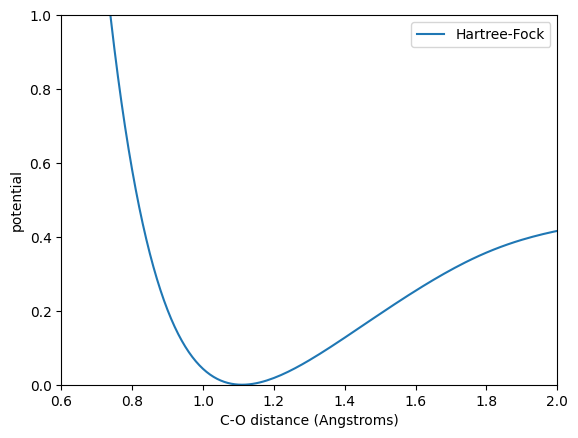

In [4]:
# import matplotlib
import matplotlib.pyplot as plt

# minimum energy
V_e = min(hf_potential)


# shift potential so the minimum value is zero
hf_potential = np.array(hf_potential) - V_e


plt.figure()
plt.plot(x , hf_potential, label='Hartree-Fock')
plt.xlim(0.6, 2.0)
plt.ylim(0, 1)
plt.ylabel('potential')
plt.xlabel('C-O distance (Angstroms)')
plt.legend()
plt.show()

Near the equilibrium C-O distance, the potential in which the nuclei live looks harmonic, i.e., it could be approximated by a quadratic function. How can we extract an appropriate force constant, $k$, from this potential? Well, if 

$$ \begin{align}
V(x) = \frac{1}{2} k(x-x_e)^2
\end{align}$$

where $x$ is the C-O distance, and $x_e$ is the equilibrium C-O distance, then 

$$ \begin{align}
k = \frac{d^2}{dx^2} V(x) 
\end{align}$$

So, we take $k$ to be the second derivative of the potential with respect to the C-O distance, evaluated at the equilibrium geometry. The second derivative of the potential can be calculated numerically, via finite differences.  You can find expressions for finite differences for different derivatives using this calculator [here](https://web.media.mit.edu/~crtaylor/calculator.html).  Using a 5-point formula for the second derivative, we can express $k$ as 

$$\begin{align}
k \approx \frac{-V(x_e + 2 h) + 16 V(x_e + h) - 30 V(x_e) + 16 V(x_e - h) - V(x_e - 2h)}{12h^2} 
\end{align}$$

where $h$ is a displacement from the equilbrium C-O distance, $x_e$. Here, we calculate $k$ in this way and visualize the harmonic and Hartree-Fock potentials together.

**IMPORTANT** Your energies in the numerator are in atomic units, so it is important to express your $h$ in the denominator also in atomic units!  We will use `dx_au` to get $h$ in atomic units.

This plot will have the bond length in Bohr units (or atomic units), so we will see that the features of this curve (the equilibrium bond length, etc) appear to be shifted by a factor $\approx 1.88973$, which is the conversion from Angstroms to Bohr units of length.

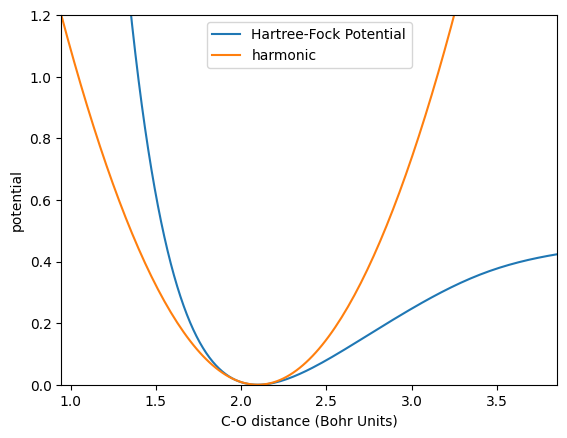

In [5]:
# equilbirum bond length - defined by CCSD potential
idx = np.argmin(hf_potential)

# equilibrium bond length in atomic units
x_e_au = x_au[idx]

# equilibrium bond length in Angstroms
x_e = x[idx]

# k = d^2 V(x) / dx^2
k = (-hf_potential[idx + 2] + 16 * hf_potential[idx + 1] - 30 * hf_potential[idx] + 16 * hf_potential[idx - 1] - hf_potential[idx]) / (12 * dx_au**2)

# harmonic potential
harmonic = 0.5 * k * (x_au-x_e_au)**2

plt.figure()
plt.plot(x_au, hf_potential, label='Hartree-Fock Potential')
plt.plot(x_au, harmonic, label='harmonic')
plt.xlim(x_au[0], x_au[-1])
plt.ylim(0, 1.2)
plt.ylabel('potential')
plt.xlabel('C-O distance (Bohr Units)')
plt.legend()
plt.show()

Clearly these potentials have some major qualitative differences, the most obvious of which is that the CCSD potential tends to some constant value in the limit of dissociation, whereas the harmonic potential does not. Indeed, for the harmonic potential, $V(x)$, 

$$ \begin{align}
\lim_{x\to\infty} V(x) = \infty 
\end{align}$$

Nonetheless, the harmonic potential does a reasonable job of approximating the Hartree-Fock one near equilibrium. Hence, we consider the quantum harmonic oscillator model to be useful for describing low-energy vibrational states only. Higher-energy states will be poorly described by this model. 

## One-Dimensional Classical Harmonic Oscillator

Now, we seek solultions to the classical harmonic oscillator problem. In this case, let us assume that the equilibrium position, $x_e = 0$, and note that we would like to solve for the position as a function of time, $x(t)$. Recall that the harmonic restoring force is linear in the displacement, 

$$ \begin{align}
F_x = -k x(t)
\end{align}$$

Classically, we can find an analytic form for how the displacement evolves over time with the help of Newton's second law,

$$\begin{align}
F_x = m a_x(t)
\end{align}$$

where the acceleration of the oscillator, $a_x(t)$, is the second time derivative of the position, i.e.,

$$\begin{align}
a_x(t) = \frac{d^2}{dt^2} x(t)
\end{align}$$

So, we seek a solution to the differential equation

$$ \begin{align}
m \frac{d^2}{dt^2} x(t) = -k x(t)
\end{align}$$ 

which has a general solution

$$ \begin{align}
x(t) = C\text{sin}\left ( \left [ k/m \right ]^{1/2} t \right ) + D \text{cos}\left( \left [ k/m \right ]^{1/2} t \right )
\end{align}$$

or 

$$\begin{align}
x(t) = A\text{sin}\left ( \left [ k/m \right ]^{1/2} t + B \right ) 
\end{align}$$

where $B$ represents a phase shift. This solution tells us that harmonic motion is sinusoidal, which we can visualize using the following code. In this case, let us take some arbitrary values for $k$, $m$, $A$, and $B$, which are all specified below. In addition to visualizing the position, $x(t)$, we will also plot the kinetic energy, $T$, and potential energy, $V$ as functions of time. 

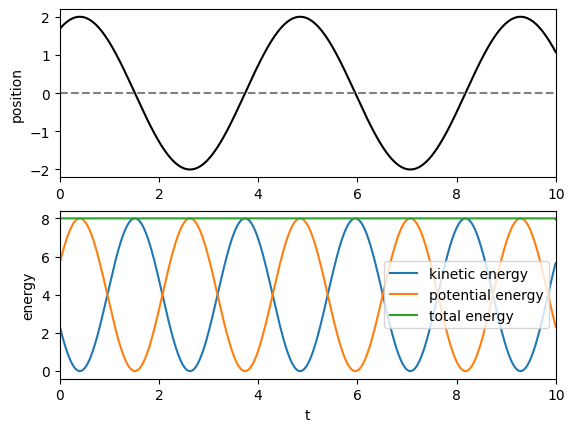

In [6]:
dt = 0.01
t = np.arange(0, 10.01, dt)

k = 4.0
m = 2.0
B = 1.0
A = 2.0

# position, x(t)
x_t = A * np.sin(np.sqrt(k/m) * t + B)

# calculate velocicty from the position using np.gradient
velocity = np.gradient(x_t, t)

# kinetic energy
T = 0.5 * m * velocity**2

# potential energy
V = 0.5 * k * x_t**2

# plot position
fig, axs = plt.subplots(2)
axs[0].plot(t, x_t, color = 'black')
axs[0].axhline(y=0.0, color='gray', linestyle='--')

axs[0].set_xlim(0, 10)
axs[0].set_ylabel('position')

# plot kinetic and potential energy
axs[1].plot(t, T, label = 'kinetic energy')
axs[1].plot(t, V, label = 'potential energy')
axs[1].plot(t, T + V, label = 'total energy')

axs[1].set_xlim(0, 10)
axs[1].set_ylabel('energy')
axs[1].set_xlabel('t')

plt.legend()
plt.show()

The displacement, $x(t)$, oscillates between $A$ and $-A$ with a frequency, $\nu$, 

$$ \begin{align}
\nu = \frac{1}{2\pi}  \left ( \frac{k}{m} \right )^{1/2}
\end{align}$$

It will be useful at times to also consider the *angular frequency*, $\omega$, which is related to $\nu$ by a factor of $2 \pi$:

$$ \begin{align}
\omega = 2 \pi \nu = \left ( \frac{k}{m} \right )^{1/2}
\end{align}$$

The kinetic and potential energy also oscillate in time, but their sum, the total energy, is constant in time. This result makes sense because the oscillator is not being driven, nor is it interacting with any sort of bath, so the total energy should be conserved. Note also that the frequency with which the the kinetic and potential energy oscillate is twice the frequency with which the position oscillates. This behavior reflects the symmetry of the potential, $V(x)$. For example, the potential energy should go to zero twice per single oscillation of the position, once as the oscillator moves past its equilibrium position in the $+x$ direction and again when it passes through equilibrium in the $-x$ direction. Similarly, the kinetic energy should go to zero twice per oscillation in the position, at the two **classical turning points**. 

The classical turning point is the point at which the potential energy is equal to the total energy and the kinetic energy is equal to zero. The term, turning point, refers to the fact that this is the point at which the oscillator stops moving and reverses direction. For the classical harmonic oscillator with 

$$ \begin{align}
x(t) = A\text{sin}\left ( \left [ k/m \right ]^{1/2} t + B \right ) 
\end{align}$$

the turning points are simply $-A$ and $A$. Let's visualize the classical turning points, total energy, and  harmonic potential together.

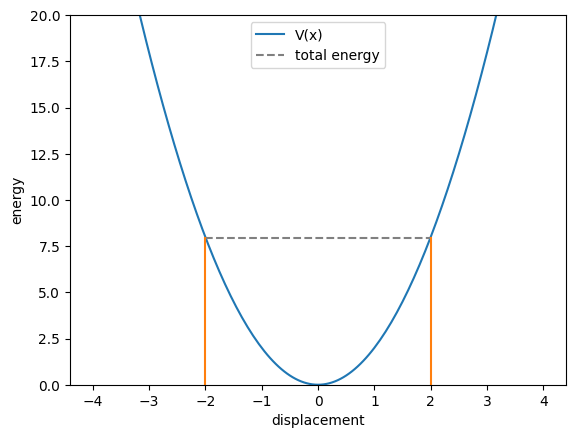

In [7]:
# total energy at time zero
energy = T[0] + V[0]

# turning points
x_max = A
x_min = -A
    
# harmonic potential. 
dx = 0.05
x = np.arange(-4, 4.05, dx)
harmonic = 0.5 * k * x**2

plt.figure()
plt.plot(x, harmonic, label='V(x)')

plt.plot([x_min, x_max], [energy, energy], color='gray', linestyle='--', label = 'total energy')
plt.plot([x_min, x_min], [0, energy], color = 'tab:orange', linestyle = '-')
plt.plot([x_max, x_max], [0, energy], color = 'tab:orange', linestyle = '-')

plt.ylim(0, 20)
plt.ylabel('energy')
plt.xlabel('displacement')
plt.legend()
plt.show()

Note that the classical harmonic oscillator will never be found with a displacement beyond the turning points. As we will find below, the situation will be different for the quantum harmonic oscillator.

## One-Dimensional Quantum Harmonic Oscillator

Now, we would like to consider the quantum mechanical treatment of the one-dimensional harmonic oscillator problem. Given the potential explored in the previous section, 

$$ \begin{align}
V(x) = \frac{1}{2} k x^2
\end{align}$$

the Hamiltonian has the form

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + V(x)
\end{align}$$

$m$ represents the mass of the oscillator, and we have assumed that $x_e = 0$. Recall from the classical harmonic oscillator problem that the force constant is related to the frequency of oscillation as

$$\begin{align}
\omega = \left ( \frac{k}{m} \right )^{1/2}
\end{align}$$

so the potential can be expressed as

$$\begin{align}
V(x) = \frac{1}{2} m \omega^2  x^2
\end{align}$$

Now, it will be convenient to introduce a constant, $\alpha$, which is defined as

$$\begin{align}
\alpha = \frac{\omega m}{\hbar}
\end{align}$$

so that the Hamiltonian can be expressed in several equivalent ways:
$$ \begin{align}
\hat{H} &= -\frac{\hbar^2}{2m}\left ( \frac{d^2}{dx^2} - \alpha^2 x^2 \right ) \\
        &= -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \frac{1}{2} m \omega^2 x^2 \\
        &= -\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \frac{1}{2} k x^2 \\
        &= \frac{\hat{p}^2}{2m} + \frac{1}{2} k x^2 \\
\end{align}$$

As was the case for the translational problems explored in the previous notebook, this Hamiltonian is time-independent, so our goal is to find the eigenfunctions that satisfy the time-independent Schrödinger equation,

$$\begin{align}
\hat{H} \psi(x) = E \psi(x)
\end{align}$$

or 

$$\begin{align}
-\frac{\hbar^2}{2m}\left ( \frac{d^2}{dx^2} - \alpha^2 x^2 \right) \psi(x) = E \psi(x)
\end{align}$$

Rerranging this equation slightly gives us

$$\begin{align}
\frac{d^2}{dx^2} \psi(x) + \left (\frac{2 m E}{\hbar^2} - \alpha^2 x^2 \right )\psi(x) = 0 
\end{align}$$

Unfortunately, we can see that this differential equation is much more complicated than any that we have encountered so far, which is attributable to the fact that the potential depends the displacement, $x$. In order to solve this equation, we find a power series solution.

**This is fairly lengthy, so we leave this derivation as optional material for the interested reader.  The solution to the energy eigenvalues is provided below this optional derivation.**


<details>
  <summary>Click to Show The Power Series Solution to the Harmonic Oscillator Schrödinger Equation</summary>

### Power Series Solution to the Schrödinger Equation

The basic idea of a power series solution to a differential equation is to assume that the function, in this case, the wave function, $\psi(x)$, can be expanded as a power series

$$ \begin{align}
\psi(x) = \sum_{n=0}^{\infty} a_n x^n = a_0 + a_1 x + a_2 x^2 + ...
\end{align}$$

This form can then be substituted back into the differential equation so that we can solve for the unknown expansion coefficients, $a_n$. Doing so, in this case, would lead to a three-term recursion relation amongst the coefficients. It turns out that a simpler, two-term recursion relation can be obtained by instead making a clever choice for the functional form of $\psi(x)$ before invoking the concept of the power series. Armed with the <b><font color='red'>i</font><font color='orange'>n</font><font color='yellow'>f</font><font color='green'>i</font><font color='blue'>n</font><font color='indigo'>i</font><font color='violet'>t</font><font color='red'>e</font> <font color='orange'>w</font><font color='yellow'>i</font><font color='green'>s</font><font color='blue'>d</font><font color='indigo'>o</font><font color='violet'>m</font></b> of already knowing the right answer, we will try

$$ \begin{align}
\psi(x) = e^{-\alpha x^2/2} f(x)
\end{align}$$

and expand $f(x)$ as a power series, rather than $\psi(x)$. So, we have

$$ \begin{align}
f(x) = \sum_{n=0}^\infty c_n x^n
\end{align}$$

and our task is to determine the coefficients, $c_n$. Let us begin by recognizing that the time-independent Schrödinger equation is a second-order differential equation, so we need to evaluate the second derivative of the wave function. The first derivative is

$$ \begin{align}
\psi^\prime(x) = -\alpha x e^{-\alpha x^2/2} f(x) + e^{-\alpha x^2/2} f^\prime(x)
\end{align}$$

and the second derivative is

$$ \begin{align}
\psi^{\prime\prime}(x) = e^{-\alpha x^2/2}\left [ -\alpha f(x) + \alpha^2 x^2 f(x) - 2\alpha x f^{\prime}(x) + f^{\prime\prime}(x) \right ]
\end{align}$$

Inserting $\psi(x)$ and $\psi^{\prime\prime}(x)$ into the Schrödinger equation yields

$$ \begin{align}
e^{-\alpha x^2/2}\left [ -\alpha f(x) + \alpha^2 x^2 f(x) - 2\alpha x f^{\prime}(x) + f^{\prime\prime}(x) \right ] + \left (\frac{2 m E}{\hbar^2} - \alpha^2 x^2 \right ) e^{-\alpha x^2/2} f(x) = 0 
\end{align}$$

which simplifies to

$$\begin{align}
f^{\prime\prime}(x) - 2\alpha x f^{\prime}(x) + \left (\frac{2 m E}{\hbar^2} - \alpha\right )  f(x) = 0 
\end{align}$$

Now, we must evaluate the first and scond derivative of $f(x)$. Recall

$$ \begin{align}
f(x) = \sum_{n=0}^{\infty} c_n x^n
\end{align}$$

so $f^{\prime}(x)$ is

$$ \begin{align}
f^{\prime}(x) &= \sum_{n = 1}^{\infty}n c_n x^{n-1} \\
&= \sum_{n = 0}^\infty n c_n x^{n-1}
\end{align}$$

where, in the second line, we note that the lower limit of the sum can be changed to zero without impacting the sum. The second derivative is

$$\begin{align}
f^{\prime\prime}(x) &= \sum_{n = 2} n(n-1) c_n x^{n-2}
\end{align}$$

By choosing a dummy index, $k = n-2$, we can adjust the summation limits so that they match those used in the first derivative expression

$$\begin{align}
f^{\prime\prime}(x) &= \sum_{k = 0} (k+2)(k+1) c_{k+2} x^k
\end{align}$$

or 

$$\begin{align}
f^{\prime\prime}(x) &= \sum_{n = 0} (n+2)(n+1) c_{n+2} x^n
\end{align}$$

Plugging these results back into 

$$ \begin{align}
f^{\prime\prime}(x) - 2\alpha x f^{\prime}(x) + \left (\frac{2 m E}{\hbar^2} - \alpha\right )  f(x) = 0 
\end{align}$$

yields

$$ \begin{align}
\sum_{n=0}^{\infty}  \left [ (n+2)(n+1) c_{n+2} - 2 \alpha n c_n + \left ( \frac{2mE}{\hbar^2} - \alpha \right ) c_n \right ] x^n = 0
\end{align}$$

Now, we note that the monomials, $x^n$, are linearly independent functions, which means that the polynomial in the above equation can only be satisfied for all values of $x$ if the coefficient in front of $x^n$ is zero, for all $n$. So we have

$$ \begin{align}
(n+2)(n+1) c_{n+2} + \left (  - 2 \alpha n + \frac{2mE}{\hbar^2} - \alpha \right ) c_n  = 0\text{, }\forall n
\end{align}$$

which leads to a two-term recursion relation

$$ \begin{align}
c_{n+2} = \frac{\alpha(2n+1) - 2mE/\hbar^2}{(n+1)(n+2)} c_n
\end{align}$$
</details>

<details>
  <summary>Click to Show the application of boundary conditions to the solution</summary>

### Applying Boundary Conditions

Having established the form of the wave function and the recursion relation for the coefficients in the power series expansion, we must now ask ourselves whether any restrictions need to be placed on the coefficients in order for the wave function to be well behaved. This exercise will be easiest if we regroup the terms in the power series slightly. First, let us assume that the coefficient $c_1$ is equal to zero. If this is the case, then all coefficients, $c_n$, with odd $n$ will also be zero, and the wave function will have the form

$$\begin{align}
\psi(x) &= e^{-\alpha x^2/2} \sum_{n = 0, 2, 4...}^{\infty} c_n x^n \\ 
&= e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l}
\end{align}$$

similarly, if $c_0 = 0$, then all coefficients, $c_n$, with even $n$ will also be zero, leading to

$$\begin{align}
\psi(x) &= e^{-\alpha x^2/2} \sum_{n = 1, 3, 5...}^{\infty} c_n x^n \\ 
&= e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1}
\end{align}$$

Now, a general form for the wave function could be expressed as a linear combination of these even and odd terms

$$ \begin{align}
\psi(x) = A e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1} + B e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l} 
\end{align}$$

Our task is not to determine the coefficients $A$, $B$, $c_0$, and $c_1$. To do so, we should ask ourselves how do these functions behave in the limit that $l$ becomes very large? Let us consider the ratio of two successive coefficients in the in the even series, $c_{2l+2}$ and $c_{2l}$:

$$ \begin{align}
\frac{c_{2l+2}}{c_{2l}} = \frac{\alpha + 4 \alpha l - 2mE/\hbar^2}{(2l+1))(2l+2)}
\end{align}$$

In the limit of large $l$, we have

$$\begin{align}
\lim_{l\to\text{large}} \frac{c_{2l+2}}{c_{2l}} = \frac{\alpha}{l}
\end{align}$$

Performing this exercise on the odd series leads to the same result. Again, armed with the <b><font color='red'>i</font><font color='orange'>n</font><font color='yellow'>f</font><font color='green'>i</font><font color='blue'>n</font><font color='indigo'>i</font><font color='violet'>t</font><font color='red'>e</font> <font color='orange'>w</font><font color='yellow'>i</font><font color='green'>s</font><font color='blue'>d</font><font color='indigo'>o</font><font color='violet'>m</font></b> of already knowing the right answer, let us attempt to find a Taylor series expansion that looks similar in the limit of large $l$. Consider the Taylor series expansion for the Gaussian function

$$\begin{align}
e^{\alpha x^2} &= \sum_{n=0} \frac{(\alpha x^2)^n}{n!} \\
&= 1 + \alpha x^2 + ... + \frac{\alpha^lx^{2l}}{l!} + \frac{\alpha^{l+1}x^{2l+1}}{(l+1)!}
\end{align}$$

Taking the ratio of the coefficients in the last two terms yields

$$ \begin{align}
\frac{\alpha^{l+1}l(l-1)(l-2)...}{\alpha^l(l+1) l (l-1)(l-2)...} = \frac{\alpha}{l+1}
\end{align}$$

and

$$\begin{align}
\lim_{l\to\text{large}} \frac{\alpha}{l+1} = \frac{\alpha}{l}
\end{align}$$

The conclusion we can draw is that, for large $l$, the power series expansion of $f(x)$ begins to look like the Gaussian function, $e^{\alpha x^2}$!

What consequences does this observation have for the wave function? Recall, we have

$$ \begin{align}
\psi(x) =  A e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1} + B e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l} 
\end{align}$$

Consider the limit as $x$ tends to infinity. In this case, $\psi(x)$ will be dominated by the large-$l$ terms, and, as $l$ gets large, each series begins to look like $e^{\alpha x^2}$. To a gross approximation, we have

$$\begin{align}
\lim_{x \to \infty} \psi(x) &\approx e^{-\alpha x^2/2} \left [A e^{\alpha x^2}  + B e^{\alpha x^2} \right ] \\
&\approx e^{\alpha x^2/2} \left [A  + B \right ]
\end{align}$$

Recall that $\alpha = 2\pi\nu m / \hbar > 0$ is a positive number, so

$$\begin{align}
\lim_{x \to \infty} \psi(x) = 0 
\end{align}$$

which clearly is not acceptable because this result implies that 

1. $\psi(x)$ would not be square integrable.
2. the probability of finding the oscillator infinitely far from equilibrium would be infinite.

Hence, we have discovered the boundary condition for this problem. 

Under what circumstances can we guarantee that $\psi(x)$ will not go to infinity as $x \to \infty$? The choice $A = B = 0$ would suffice, except that $|\psi(x)|^2=0$ for all $x$, which implies that there is zero probability of finding the oscillator at any displacement. This result does not make sense physically and is rejected. If either $A$ or $B$ are nonzero, then the power series expansion for $f(x)$ must truncate to avoid the wave function tending to infinity at large displacements. The way to accomplish this goal is to require that, for some coefficient $c_v$, the next coefficient in the series, $c_{v+2}$, must vanish. In this case, we would have

$$\begin{align}
c_{v+2} = 0 = \frac{\alpha ( 2 v + 1) - 2mE/\hbar^2}{(v+1)(v+2)} c_v
\end{align}$$

</details>


   

### Final Energy Eigenvalue Expression
Solving for $E$ and using $\alpha = \omega m / \hbar$ yields

$$\begin{align}
E_n = \hbar\omega\left ( v + \frac{1}{2} \right) = h\nu \left( v + \frac{1}{2} \right)
\end{align}$$



where we have added a subscript "$v$" to the energy to indicate that the energy of the state is determined by the vibrational quantum number, $v$. So, what have we learned?

1. The energy of the QHO is quantized, and $v$ is the quantum number. $v = 0, 1, 2, ...$ are allowed values for the quantum number.
2. Once again, the application of boundary conditions has led to the quantization of the energy.
3. The energy leves for a QHO are evenly spaced (by $\hbar \omega$ or $h\nu$).
4. If $v=0$ is allowed (it is), then they lowest energy is
   $$\begin{align}
   E_0 = \frac{1}{2} \hbar \omega = \frac{1}{2} h \nu
   \end{align}$$
   which is called the "zero-point" energy. Since there is no lower energy leven, the interpretation is that the energy of the QHO is non-zero, even at zero kelvin.


### QHO Wave Functions

In the previous section, the solutions to the Schrödinger equation were given as a linear combination of polynomials involving either even and odd powers of $x$, i.e.,

$$ \begin{align}
\psi_v(x) = A e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l+1} x^{2l+1} + B e^{-\alpha x^2/2} \sum_{l=0}^{\infty} c_{2l} x^{2l} 
\end{align}$$

where we have added a subscript, $v$, to denote the quantum number for the state. Now, it becomes clear that, in order for these functions to be well behaved, we should include only one of these sums, based on whether $v$ is even or odd. The reason is that, if, for example, $v$ is even, then the even series will truncate, but the odd series will not. Hence, for even $v,$ the coefficient $A$ must vanish. Similarly, if $v$ is odd, then the odd series will truncate, but the even one will not. Hence, for odd $v,$ the coefficient $B$ must vanish. In other words, an eigenfunction of the QHO Hamiltonian, $\psi_v(x)$ will consist of one of these sums, but not both. 

As an example, consider the state with $v = 2,$ where $A$ must be equal to zero. 

$$\begin{align}
\psi_2(x) = B \sum_{l=0}^\infty c_{2l} x^{2l} e^{-\alpha x^2/2}
\end{align}$$

What are the coefficients, $c_{2l}$?  Recall,

$$ \begin{align}
c_{n+2} = \frac{\alpha (2n+1) - 2mE/\hbar^2}{(n+1)(n+2)} c_n 
\end{align}$$

Given that

$$\begin{align}
\alpha = 2\pi \nu m / \hbar
\end{align}$$

and

$$\begin{align}
E = h \nu ( v + 1/2)
\end{align}$$

we can show that

$$\begin{align}
\frac{m E}{\hbar^2} = \alpha ( v + 1/2)
\end{align}$$

so the recursion relationship becomes

$$\begin{align}
c_{n+2} = \frac{2\alpha ( n + 1/2) - 2\alpha ( v + 1/2)}{(n+1)(n+2)} c_n
\end{align}$$

Now, it is clear that the numerator will vanish and the series will truncate when $n = v.$ So, for $v = 2$, we can assume that $c_0$ can be determined via normalization, and then we have

$$\begin{align}
c_2 &= \frac{2\alpha(0 - 2)}{(0+1)(0+2)}c_0 = -2\alpha c_0 \\
c_4 &= \frac{2\alpha(2 - 2)}{(2+1)(2+2)}c_2 = 0 \\
c_6 &= 0 \\
\text{etc.}
\end{align}$$

and

$$ \begin{align}
\psi_2(x) = B c_0 \left ( 1 - 2\alpha x^2 \right )e^{-\alpha x^2/2} 
\end{align}$$

We can absorb $B$ and $c_0$ into a single normalization constant, $N_2$

$$\begin{align}
\psi_2(x) = N_2 \left ( 1 - 2\alpha x^2 \right )e^{-\alpha x^2/2}
\end{align}$$

or, after normalization

$$\begin{align}
\psi_2(x) = \left ( \frac{\alpha}{4\pi} \right)^{1/4} \left ( 1 - 2\alpha x^2 \right )e^{-\alpha x^2/2}
\end{align}$$

In general, the wave function for state $v$ has the form


$$\begin{align}
\psi_v(x) = \left ( 2^v v! \right )^{-1/2} \left ( \frac{\alpha}{\pi} \right)^{1/4} e^{-\alpha x^2/2} H_v(\alpha^{1/2} x)
\end{align}$$

where $H_v$ represents a special polynomial function called a Hermite polynomial, the first few of which are tabulated here:


| $H_v(z)$ | symmetry |
|---|---|
| $H_0 = 1$ | even |
| $H_1 = 2z$ | odd |
| $H_2 = 4z^2-2$ | even |
| $H_3 = 8z^3 - 12z$ | odd |

Because the Gaussian part of the wave function, $e^{-\alpha x^2/2}$, is even in the displacement coordinate, the symmetry of the Hermite polynomials determines the overall symmetry of the wave function. Let us visualize the first few QHO wave functions using the built-in Hermite polynomial functionality in scipy library. For this excercise, we will use arbitrary values for the parameters, $\alpha$ and $m$, that are chosen for ease of visualization. 

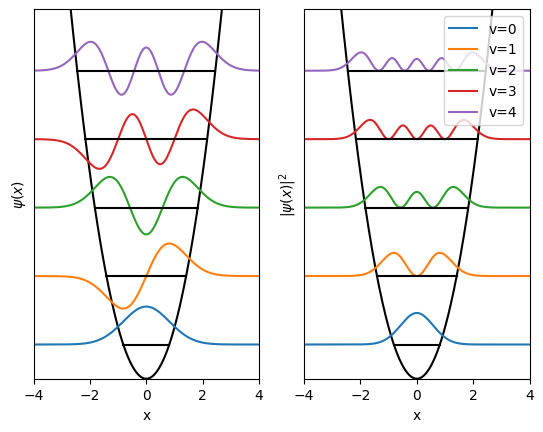

In [8]:
# for hermite polynomials
import scipy
import numpy as np
from matplotlib import pyplot as plt

# for the factorial function
import math

# displacements
x = np.linspace(-4, 4, 200)

# arbitrary parameters
alpha = 1.5
hbar = 1.0
m = 1.0

# frequency and angular frequency
nu = alpha / ( 2 * np.pi * m / hbar)
omega = nu * 2 * np.pi

# potential
potential = 2 * m * nu**2 * np.pi**2 * x**2

# energy, eigenfunctions, and turning points
wfn = []
energy = []
x_tp = []
for v in range (0, 5):
    # hermite polynomial
    H_v = scipy.special.hermite(v)

    # normalization constant
    N_v = ( 2**v * math.factorial(v))**(-0.5) * (alpha/np.pi)**0.25

    # wave function
    psi_v = N_v * np.exp(-alpha*x**2/2) * H_v(alpha**0.5 * x)
    
    wfn.append(psi_v)

    # energy
    my_energy = hbar * omega * ( v + 0.5)
    energy.append(my_energy)

    # turning point E = V(x) = 1/2 k x^2 = 2 m nu^2 pi^2 x^2
    my_x = np.sqrt(my_energy / (2 * m * nu**2 * np.pi**2 ))
    x_tp.append(my_x)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_yticks(ticks=[])
ax1.set_ylabel(r'$\psi(x)$')
ax1.set_xlabel('x')

ax1.plot(x, potential, color = 'black')

ax1.plot(x, wfn[0] + energy[0], label = 'v=0')
ax1.plot(x, wfn[1] + energy[1], label = 'v=1')
ax1.plot(x, wfn[2] + energy[2], label = 'v=2')
ax1.plot(x, wfn[3] + energy[3], label = 'v=3')
ax1.plot(x, wfn[4] + energy[4], label = 'v=4')

for i in range (0, 5):
    ax1.plot([-x_tp[i], x_tp[i]], [energy[i], energy[i]], color='black')

ax1.set_ylim(0, energy[4] * 1.2)
ax1.set_xlim(-4, 4)

ax2.set_yticks(ticks=[])
ax2.set_ylabel(r'$|\psi(x)|^2$')
ax2.set_xlabel('x')

ax2.plot(x, potential, color = 'black')

ax2.plot(x, wfn[0]**2 + energy[0], label = 'v=0')
ax2.plot(x, wfn[1]**2 + energy[1], label = 'v=1')
ax2.plot(x, wfn[2]**2 + energy[2], label = 'v=2')
ax2.plot(x, wfn[3]**2 + energy[3], label = 'v=3')
ax2.plot(x, wfn[4]**2 + energy[4], label = 'v=4')

for i in range (0, 5):
    ax2.plot([-x_tp[i], x_tp[i]], [energy[i], energy[i]], color='black')

ax2.set_ylim(0, energy[4] * 1.2)
ax2.set_xlim(-4, 4)

plt.legend(loc='upper right')
plt.show()



In this figure, the horizontal lines represent the classically "allowed" regions, where $V(x) \le E_v$. The QHO wave functions oscillate within this region and decay in the classically forbidden regions, where $V(x) > E_v$. Recall that, classically, the total energy is the sum of potential energy, $V(x)$, and kinetic energy, $T_x$, 

$$ \begin{align}
E = T_x + V(x)
\end{align}$$

Having a potential energy that exceeds the total energy requires a negative kinetic energy, which implies that the momentum is imaginary - a nonsensical result. If the QHO has a non-zero probability of existing in the classically forbidden region, do we have a similar nonsensical result? Not quite. Recall that, quantum mechanically, one cannot state that the energy is *exactly* equal to a given value unless the state is an eigenfunction of the energy operator (the Hamiltonian). Similarly, one cannot state that the potential or kinetic energy are known, exactly, unless the state is an eigenfunction of the potential or kinetic energy operators. We deal, instead, with expectation values, i.e.,

$$ \begin{align}
\langle E \rangle = \langle T_x \rangle + \langle V(x) \rangle
\end{align}$$

or 

$$ \begin{align}
E = \langle T_x \rangle + \langle V(x) \rangle
\end{align}$$

if the state is an eigenfunction of the Hamiltonian. For the QHO problem, $\hat{T}$ does not commute with the Hamiltonian, nor does $V(x)$, so, it is impossible to define simultaneous eigenfunctions of these three operators, so we can only predict the expecation values, $\langle T\rangle $ and $\langle V(x)\rangle $. In one of the previous notebooks, we proved that 

$$ \begin{align}
\langle T_x \rangle  \ge 0
\end{align}$$

which implies that

$$ \begin{align}
\langle V(x) \rangle  \le E
\end{align}$$

However, because we cannot know the exact value of $V(x)$ without taking a measurement, we cannot say with certainty that $V(x) < E$.

### Tunneling and the Correspondence Principle

The penetration of the QHO wave functions into the classically forbidden regions is called tunneling. What is the probability of a QHO in the ground state $(v=0)$ being found beyond one of the classical turning points? If the wave function is normalized, then the tunneling probability for any QHO state, $\psi_v(x)$, is given by

$$ \begin{align}
P = \int_{-\infty}^{-x_\text{tp}} |\psi_v(x)|^2 dx + \int_{x_\text{tp}}^\infty |\psi_v(x)|^2 dx
\end{align}$$

where $\pm x_\text{tp}$ represent the classical turning points, which can be determined via

$$ \begin{align}
x_\text{tp} &= \pm \left [ 2 E_v / k \right ]^{1/2} \\
&= \pm \left [ E_v / (2 m \nu^2 \pi^2) \right ]^{1/2}
\end{align}$$

with $E_v = h\nu ( v + 1/2)$. It turns out that this probability is slightly easier to evaluate as

$$\begin{align}
P &= 1 - \int_{-x_\text{tp}}^{x_\text{tp}} |\psi_v(x)|^2 dx \\
 &= 1 - 2 \int_{0}^{x_\text{tp}} |\psi_v(x)|^2 dx \\
\end{align}$$

where, in the second line, we have recognized that the probability density is symmetric about $x=0$. For the ground state, we have 

$$ \begin{align}
\psi_0(x) = \left ( \frac{\alpha}{\pi} \right ) ^{1/4} e^{-\alpha x^2/2}
\end{align}$$

and

$$ \begin{align}
x_\text{tp} &= \pm \left [ h \nu / k \right ]^{1/2}
\end{align}$$

so the probability is 

$$ \begin{align}
P = 1 - 2\int_{0}^{x_\text{tp}} \left ( \frac{\alpha}{\pi} \right ) ^{1/2} e^{-\alpha x^2} dx
\end{align}$$

Now, using

$$ \begin{align}
\nu = \frac{1}{2\pi}\left ( \frac{k}{m} \right ) ^{1/2}
\end{align}$$

and

$$ \begin{align}
k = \nu^2(2 \pi)^2 m
\end{align}$$

we can show that

$$ \begin{align}
x_\text{tp} = \alpha^{-1/2}
\end{align}$$

so

$$ \begin{align}
P = 1 - 2\int_{0}^{\alpha^{-1/2}} \left ( \frac{\alpha}{\pi} \right ) ^{1/2} e^{-\alpha x^2} dx 
\end{align}$$

We perform a change of variables so that 

$$ \begin{align}
\xi &= \alpha^{1/2} x \\
d\xi &= \alpha^{1/2} dx \\
\xi_\text{tp} &=  \alpha^{1/2} x_\text{tp} = 1
\end{align}$$

which leads to 

$$\begin{align}
P &= 1 - \frac{2}{\pi^{1/2}} \int_{0}^1 e^{-\xi^2} d\xi \\
&= 1 - \text{erf}(1) \\
&= 0.1573
\end{align}
$$

where erf(1) is [the error function](https://mathworld.wolfram.com/Erf.html). According to this analysis, there is a $\approx 16\%$ probability that an oscillator in the $v=0$ will be found past the classical turning point.

How does the tunneling probability change with the quantum number, $v$? The **Bohr Correspondence Principle** states that quantum mechanics should recover classical results in the limit of large quantum numbers. Since the tunneling probability is zero for a classical harmonic oscillator, we should expect the tunneling probability to decrease with increasing $v$. The following Python code calculates the tunneling probability numerically so that we can visualize this trend, for up to $v=100.$

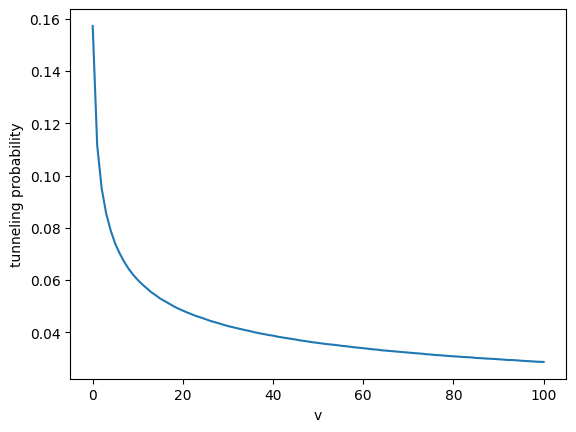

In [9]:
# energy, eigenfunctions, and turning points
P = []
for v in range (0, 101):

    # energy
    my_energy = hbar * omega * ( v + 0.5)

    # turning point E = V(x) = 1/2 k x^2 = 2 m nu^2 pi^2 x^2
    my_x = np.sqrt(my_energy / (2 * m * nu**2 * np.pi**2 ))

    # grid for integral [-x_tp:x_tp]
    x = np.arange(-my_x, my_x + 0.001, 0.001)

    # hermite polynomial
    H_v = scipy.special.hermite(v)

    # normalization constant
    N_v = ( 2**v * math.factorial(v))**(-0.5) * (alpha/np.pi)**0.25

    # wave function
    psi_v = N_v * np.exp(-alpha*x**2/2) * H_v(alpha**0.5 * x)

    # P = 1 - 2 int...
    my_P = 1.0 - np.trapz(psi_v.conj() * psi_v, x)

    P.append(my_P)

fig = plt.plot()
plt.ylabel('tunneling probability')
plt.xlabel('v')
plt.plot(P)
plt.show()

Indeed, this numerical study demonstrates that the tunneling probability decreases monotonically with increasing $v$, as expected. 

A second manifiestation of the Bohr Correspondence Principle is the evolution of the overall shape of the probability density toward the classical limit, which is [given by](https://en.wikipedia.org/wiki/Classical_probability_density)

$$\begin{align}
P = \frac{1}{\pi (x_\text{tp}^2 - x^2)^{1/2}}
\end{align}$$

The following Python code calculates the probability distribution for states with $v \le 30$ so that we can compare the quantum distribution to the classical one.

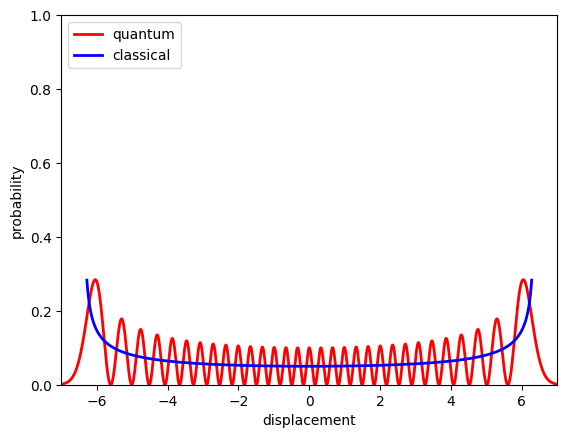

In [10]:
fig = plt.figure()

# lists of 2d line objects ... each frame will be an element in the list
line2, = plt.plot([], [], color = 'red', lw=2, label = 'quantum')
line1, = plt.plot([], [], color = 'blue', lw=2, label = 'classical')

# figure details
plt.xlim(-7, 7)
plt.ylim(0, 1)
plt.xlabel('displacement')
plt.ylabel('probability')
plt.legend(loc='upper left')

# animation function
def probability_density(v):

    # energy
    my_energy = hbar * omega * ( v + 0.5)

    # turning point E = V(x) = 1/2 k x^2 = 2 m nu^2 pi^2 x^2
    my_x_tp = np.sqrt(my_energy / (2 * m * nu**2 * np.pi**2 ))

    # grid [-x_tp:x_tp]
    x_classical = np.linspace(-my_x_tp+0.1, my_x_tp-0.1, 5000, dtype = np.float64)

    # grid [-7:7]
    x_quantum = np.linspace(-7, 7, 5000, dtype = np.float64)

    # hermite polynomial
    H_v = scipy.special.hermite(v)

    # normalization constant
    N_v = ( 2**v * math.factorial(v))**(-0.5) * (alpha/np.pi)**0.25

    # wave function
    psi_v = N_v * np.exp(-alpha*x_quantum**2/2) * H_v(alpha**0.5 * x_quantum)
    P_quantum = psi_v.conj() * psi_v

    # P = 1/(pi * sqrt(xtp^2 - x^2))
    P_classical = 1.0 / ( np.pi * np.sqrt(my_x_tp**2 - x_classical**2))

    P.append(my_P)

    line1.set_data(x_classical, P_classical)
    line2.set_data(x_quantum, P_quantum)
    
    return (line1, line2)

from matplotlib import animation

anim = animation.FuncAnimation(fig, probability_density, frames=31, interval=300, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### Selection Rules

The QHO model is a model for molecular vibrations. As such, we can use it to predict not only vibrational energy levels, but also spectra. Specifically, we can predict which transitions are "allowed" or "forbidden" based on selection rules that can be derived mathematically. 

#### Fermi's Golden Rule

Fermi's Golden Rule is a result derived from time-dependent perturbation theory that allows us to predict the probability that a system will transition between energy states $\psi_i$ and $\psi_f$ when interacting with a time-dependent external perturbation, which is represented by the operator, $\hat{H}^\prime.$ If the perturbation has some angular frequency component, $\omega$, that is consistent with the energy difference between states $\psi_i$ and $\psi_f$, $\hbar \omega$, then the probability of observing a transition between these states is proportional to the square modulus of an integral involving these states and the perturbation operator:

$$ \begin{align}
P_{i\to f} \propto |\langle \psi_i | \hat{H}^\prime | \psi_f \rangle |^2
\end{align}$$


For light-mediated transitions, the perturbing operator is

$$\begin{align}
\hat{H}^\prime = \vec{\epsilon}(t) \cdot \hat{\mu}
\end{align}$$

where $\vec{\epsilon}(t)$ is the complex amplitude of a time-dependent electric field, and $\hat{\mu}$ represents the dipole operator for the system.  These quantities are both vector quantities:

$$\begin{align}
\vec{\epsilon}(t) &= \epsilon_x \vec{i} + \epsilon_y \vec{j} + \epsilon_z\vec{k} \\
\hat{\mu} &= \hat{\mu}_x \vec{i} + \hat{\mu}_y \vec{j} + \hat{\mu}_z\vec{k}\\
\end{align}$$

where $\vec{i},$ $\vec{j},$ and $\vec{k}$ are the unit vectors in the $x,$ $y,$ and $z$ directions, respectively.

For this perturbation, the transition probability is

$$ \begin{align}
P_{i\to f} \propto |\langle \psi_i | \vec{\epsilon}(t)\cdot \hat{\mu}|\psi_f \rangle |^2
\end{align}$$

If the light is polarized in the $x$ direction, then $\epsilon_y = \epsilon_z = 0,$ and this probability simplifies to 

$$\begin{align}
P_{i\to f} \propto |\epsilon_x|^2 |\langle \psi_i | \hat{\mu}_x |\psi_f \rangle |^2
\end{align}$$

The quantity, $\langle \psi_i | \hat{\mu}_x |\psi_f \rangle,$ is referred to as a "transition dipole" matrix element. The dependence of the transition probability on this quantity is related to the fact that, in order for the system to interact with an external electric field, it must exhibit a change in its dipole moment, at least transitorily. Note that the transition probability is also proportional to $|\epsilon_x|^2$, which, itself, is proportional to the intensity of the light. Hence, the transition probability increases with increased intensity. 

#### Fermi's Golden Rule for Molecular Vibrations

Consider a vibrational mode in a molecular system that is modeled as a harmonic oscillator. For simplicity, let consider only a diatomic molecule. As discussed in the next section, vibrations in such a molecule can be described by the one-dimensional QHO model. Given the solutions to the Schrödinger equation derived above, we can use Fermi's Golden Rule to examine light-mediated transitions between vibrational states, $v$ and $v^\prime$. Assuming that the frequency-matching condition is met by the external perturbation, we have

$$ \begin{align}
P_{v \to v^\prime} \propto | \langle \psi_{v^\prime}| \hat{\mu}_x | \psi_v \rangle|^2 
\end{align}$$

The dipole operator is proportional to the displacement coordinate, $x$, so we really only need to consider

$$ \begin{align}
P_{v \to v^\prime} \propto | \langle \psi_{v^\prime}| x | \psi_v \rangle|^2 
\end{align}$$

Now, recall that the QHO wave functions have the form 

$$\begin{align}
\psi_v(x) = N_v e^{-\alpha x^2/2} H_v(\alpha^{1/2} x)
\end{align}$$

with

$$ \begin{align}
N_v = (2^v v!)^{-1/2} \left ( \frac{\alpha}{\pi}\right )^{1/4}
\end{align}$$

Given states of these form, what are the selection rules? In other words, for what $v$ and $v^\prime$ is the integral $\langle \psi_{v^\prime}| x | \psi_v \rangle,$ and, thus, $P_{v\to v^\prime}$, nonzero? We can answer that question relatively easily with the following two properties:

1. **Orthonormality**: Normalized QHO eigenfunctions form an orthonormal set:
   $$ \begin{align}
   \langle \psi_{v^\prime} (x) | \psi_{v}(x) \rangle = \delta_{vv^\prime}
   \end{align}$$

2. **Recursion Relations**: Hermite polynomials satisfy the following recursion relations:
   $$ \begin{align}
   z H_n(z) = nH_{n-1}(z) + \frac{1}{2}H_{n+1}(z)
   \end{align}$$

Consider the matrix element

$$\begin{align}
\langle \psi_{v^\prime} | x | \psi_v \rangle = N_{v^\prime} N_v \int_{-\infty}^\infty e^{-\alpha x^2} H_{v^\prime}(\alpha^{1/2}x) x H_v(\alpha^{1/2}x) dx
\end{align}$$

We use a change of variables such that

$$\begin{align}
z &= \alpha^{1/2} x \\
x &= \alpha^{-1/2} z \\
dx &= \alpha^{-1/2} dz
\end{align}$$

to give 

$$\begin{align}
\langle \psi_{v^\prime} | x | \psi_v \rangle = N_{v^\prime} N_v \frac{1}{\alpha} \int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) z H_v(z) dz
\end{align}$$

Now, the recursion relations for the Hermite polynomials say

$$ \begin{align}
z H_v(z) = v H_{v-1}(z) + \frac{1}{2} H_{v+1}(z)
\end{align}$$

As such, we split the matrix element into two terms

$$\begin{align}
\langle \psi_{v^\prime} | x | \psi_v \rangle = N_{v^\prime} N_v \frac{1}{\alpha} \left [ v \int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v-1}(z) dz + \frac{1}{2} \int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v+1}(z) dz \right ] 
\end{align}$$

These integrals are proportional to overlaps between QHO wave functions, i.e.,

$$\begin{align}
\int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v-1}(z) dz \propto \langle \psi_{v^\prime}|\psi_{v-1}\rangle = \delta_{v^\prime(v-1)}
\end{align}$$
and
$$\begin{align}
\int_{-\infty}^\infty e^{-z^2} H_{v^\prime}(z) H_{v+1}(z) dz \propto \langle \psi_{v^\prime}|\psi_{v-1}\rangle = \delta_{v^\prime(v+1)}
\end{align}$$

which implies that 

$$ \begin{align}
P_{v \to v^\prime} \propto | A \delta_{v^\prime(v-1)} + B \delta_{v^\prime(v+1)} |^2 
\end{align}$$

where $A$ and $B$ are constants. In order for $P_{v \to v^\prime}$ to be nonzero, we must have either

$$ \begin{align}
v^\prime = v - 1 
\end{align}$$

or 

$$ \begin{align}
v^\prime = v + 1
\end{align}$$

In order words, the change in the vibrational quantum number $\Delta v = v^\prime - v$ must be 

$$\begin{align}
\Delta v = \pm 1
\end{align}$$

This analysis indicates that, for a QHO, the only allowed transitions are between adjacent energy levels. 


Now, we note that we can arrive at part of the selection rule story by considering only the symmetry of the wave functions. Recall that QHO wave functions can have either even or odd symmetry, based on the symmetry of the Hermite polynomials. For even $v$, the wave functions are even in the displacement coordinate. For odd $v$, the wave functions have odd symmetry. The matrix element that determines whether a vibrational transition is allowed or forbidden is $\langle \psi_{v^\prime} | x | \psi_v \rangle$. This integral will only be non-zero if the products of the symmetries of $\psi_{v^\prime},$ $\psi_{v},$ and the operator, $x,$ is even. Because $x$ is odd, the products of the symmetries of $\psi_{v^\prime}$ and $\psi_{v}$ must be odd. This condition is consistent with but weaker than the condition derived above.

Before moving on, we note that, in addition to the $\Delta v = \pm 1$ selection rule, there are other, more physical rules that apply to different types of vibrational spectroscopy. For IR spectroscopy, transitions will only be observed for vibrational modes that result in a change in the dipole moment of the molecule (called "IR active" modes). We can rationalize this rule by recognizing that the molecule interacts with an electric field through its dipole moment. If the dipole moment does not change with the vibration, then an oscillating electric field cannot couple to that particular vibrational mode. For Raman spectroscopy, the selection rule is different. "Raman-active" vibrational modes result in a change in the polarizability of the molecule.

## Connections to Computational Chemistry

### Harmonic Frequency Analysis

Many quantum chemistry packages support vibrational analyses on molecular systems that yield both vibrational energies and the normal modes, which are the independent vibrational modes for the molecule. Linear and non-linear molecules possess $3N-5$ and $3N-6$ vibrational degrees of freedom, respectively, where $N$ is the number of atoms. Each of the normal modes can be treated as an independent quantum harmonic oscillator, the energy of which is the same as that derived above. As such, the total vibrational energy is

$$\begin{align}
E_\text{vib} = \sum_i h \nu_i ( v_i + 1/2 ) = \sum_i \hbar \omega (v_i + 1/2)
\end{align}$$

where $\nu_i$ is the frequency for the $i$th normal mode. At zero kelvin, only the $v_i=0$ state is populated for each of these modes, so the total zero-point energy is

$$\begin{align}
E_\text{ZPE} = \frac{1}{2} \sum_i h \nu_i = \frac{1}{2} \sum_i \hbar \omega_i
\end{align}$$

The harmonic vibrational frequencies can be determined using the method of [F and G matrices](https://en.wikipedia.org/wiki/GF_method), for example. Let us consider the simplest case, a heteronuclear diatomic molecule, $CO$. As discussed above, one can calculate the potential energy curve as a function of the C-O distance using a quantum chemistry method such as coupled cluster theory. The potential near the equilibrium geometry can then be approximated with a harmonic one, where the force constant is defined by the second derivative of the calculated potential. Here is the same Python code used above to visualize the calculated and harmonic potentials.

Now, we can write down a Hamiltonian for the nuclei that experience this potential:

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2 m_1}\frac{d^2}{dx_1^2} -\frac{\hbar^2}{2 m_2}\frac{d^2}{dx_2^2} + \frac{1}{2}k (x_2 - x_1 - x_e)^2
\end{align}$$

where $m_1$ and $m_2$ represent the masses of hydrogen atoms 1 and 2, respectively, and $x_1$ and $x_2$ represent the respective coordinates. This Hamiltonian depends on the coordinates of two particles, but through a coordinate transformation, it can be re-expressed as a sum of Hamiltonians, one representing the translational motion of the entire molecule and the other representing internal motion. We are concerned only with the internal (vibrational) motion, and the relevant Hamiltonian is

$$ \begin{align}
\hat{H} = -\frac{\hbar^2}{2 \mu}\frac{d^2}{dx^2} + \frac{1}{2}k (x - x_e)^2
\end{align}$$

where $x = x_2 - x_1$ and $\mu$ is the reduced mass

$$\begin{align}
\mu = \frac{m_1 m_2}{m_1 + m_2}
\end{align}$$

This Hamiltonian resembles the QHO Hamiltonian for an effective particle of mass, $\mu$. As such, we can apply the QHO model directly to this Hamiltonian, and the vibrational frequency should be

$$\begin{align}
\nu = \frac{1}{2\pi} \left ( \frac{k}{\mu} \right )^{1/2}
\end{align}$$

We can determine $\nu$ using the value for $k$ extracted from the HF potential energy curve we computed earlier.

## Important Points about Units

- We have computed our $k$ value in atomic units
- We typically report atomic masses in atomic mass units, which are not the same as atomic units
- We will want to convert our reduced mass to atomic units so that our frequency can be in a common unit system
- We should report our fundamental frequency in a unit system that aligns with spectroscopic conventions, which for vibrational spectroscopy is the wavenumber $\bar{\nu}$ in ${\rm cm}^{-1}$

Let's think through how we can perform the necessary unit conversion.

**Atomic Mass Unit** Is defined such that $1 \: {\rm AMU} = \frac{m_{\rm ^{12}C}}{12}$, where $m_{{\rm ^{12}C}}$ is the mass of carbon 12.

**Atomic Unit of Mass** Is defined such that $1 \: {\rm a.u.} = m_{\rm e}$, where $m_{\rm e}$ is the mass of an electron.


Let's think through how we can perform the necessary unit conversion.

**Atomic Mass Unit** is defined such that  
$$1 \: \text{AMU} = \frac{m_{\rm ^{12}C}}{12},$$  
where $ m_{\rm ^{12}C} $ is the mass of a carbon-12 atom.

**Atomic Unit of Mass** is defined such that  
$$1 \: \text{a.u.} = m_{\rm e},$$  
where $ m_{\rm e} $ is the mass of an electron.

---

### Unit Conversion Question 1

How many atomic units of mass (a.u.) are there in one atomic mass unit (AMU)?  
In other words, convert $ 1 \: \text{AMU} $ to atomic units of mass.

<details>
<summary><strong>💡 Click to reveal the worked solution</strong></summary>

We are asked to convert from AMU to atomic units of mass (electron masses).

We start by noting the following values:

- $ 1 \: \text{AMU} = 1.66053906660 \times 10^{-27} \: \text{kg} $
- $ 1 \: \text{a.u.} = m_{\rm e} = 9.1093837015 \times 10^{-31} \: \text{kg} $

Now compute the ratio:

$$
\frac{1 \: \text{AMU}}{1 \: \text{a.u.}} = \frac{1.66053906660 \times 10^{-27} \: \text{kg}}{9.1093837015 \times 10^{-31} \: \text{kg}} \approx 1822.888
$$

So,
$$
1 \: \text{AMU} \approx 1822.888 \: \text{a.u.}
$$

</details>

<br>
<br>
Now if we compute the frequency using $k$ and $\mu$ both in atomic units, we will have a frequency in inverse atomic units of time.

**Atomic Unit of Time** is defined such that  
$$1 \: \text{a.u.} = 2.418884326509 \times 10^{-17} \: \text{s}$$  

So the atomic unit of frequency is the inverse:

$$
1 \: \text{a.u. of frequency} = \frac{1}{2.418884326509 \times 10^{-17} \: \text{s}} \approx 4.134137333649 \times 10^{16} \: \text{Hz}
$$


Thus, if we take our values of $k$ and $\mu$ in atomic units, we can compute the frequency in inverse seconds as

$$ \nu \; \; (\text{in \; s}^{-1}) = \frac{1}{2 \pi} \sqrt{\frac{k}{\mu}} \times 4.134137333649 \times 10^{16} $$

## Spectroscopic units
Very commonly, vibrational spectra are reported using wavenumbers in inverse centimeters ($\bar{\nu} \; \text{in} \; \text{cm}^{-1}$) rather than frequency in Hertz ($\nu \; \text{in} \; \text{s}^-1$).  We can perform one 
final manipulation from our frequency in seconds to get to wavenumbers, which is to divide by the speed of light in $\frac{\text{cm}}{\text{s}}$:

$$ \bar{\nu} = \frac{\nu}{c} $$



### ❓ Question

What is the single **conversion factor** that allows you to convert a vibrational frequency expressed in atomic units of frequency (i.e., $ \nu_{\text{a.u.}} $) directly into wavenumbers (in $\text{cm}^{-1} $)?

That is, find the value of the constant $ \alpha $ such that:

$$
\bar{\nu} \; (\text{in} \; \text{cm}^{-1}) = \alpha \times \nu_{\text{a.u.}}
$$

<details>
<summary><strong>💡 Click to reveal the worked solution</strong></summary>

We begin by converting from atomic units of frequency to frequency in Hz (s$^{-1}$), and then to wavenumbers (cm$^{-1}$).

---

**Step 1: Convert atomic units of frequency to Hz**

The atomic unit of time is:

$$
1 \: \text{a.u.} = 2.418884326509 \times 10^{-17} \: \text{s}
$$

So the atomic unit of frequency is the inverse:

$$
1 \: \text{a.u. of frequency} = \frac{1}{2.418884326509 \times 10^{-17} \: \text{s}} \approx 4.134137333649 \times 10^{16} \: \text{Hz}
$$

---

**Step 2: Convert Hz to cm$^{-1}$**

The speed of light is:

$$
c = 2.99792458 \times 10^{10} \: \text{cm/s}
$$

So:

$$
1 \: \text{Hz} = \frac{1}{2.99792458 \times 10^{10}} \: \text{cm}^{-1} \approx 3.335640951981 \times 10^{-11} \: \text{cm}^{-1}
$$

---

**Step 3: Multiply the two conversions**

$$
\alpha = \left(4.134137333649 \times 10^{16}\right) \times \left(3.335640951981 \times 10^{-11}\right)
$$

$$
\alpha \approx 1378999.77 \: \text{cm}^{-1}
$$

---

✅ **Final Answer:**

$$
\boxed{1 \: \text{a.u. of frequency} \approx 1378999.77 \: \text{cm}^{-1}}
$$

So you can use this constant to convert vibrational frequencies in atomic units directly into wavenumbers.

</details>

<br>
<br>
**In the following markdown cell, we will assign these conversion constants for subsequent use in determining the fundamental of CO in wavenumbers.

In [11]:
# conversion from AMU to atomic units
amu_to_au = 1822.888

# conversion from atomic units of frequency to wavenumbers in inverse centimeters
au_to_inv_cm = 1378999.77

In the next cell, we will set up the calculation of the fundamental frequency from our HF scan of the C-O stretch.

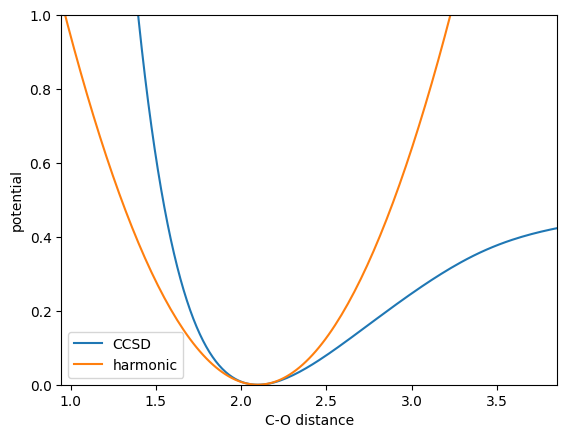

In [12]:
# equilbirum bond length
idx = np.argmin(hf_potential)
x_e_au = x_au[idx]

# k = d^2 V(x) / dx^2
k = (-hf_potential[idx + 2] + 16 * hf_potential[idx + 1] - 30 * hf_potential[idx] + 16 * hf_potential[idx - 1] - hf_potential[idx+2]) / (12 * dx_au**2)

# define reduced mass of carbon monoxide first in AMU
m_C = 12.0 # mass of ^12C in AMU
m_O = 15.99491461956 # mass of ^16O in AMU

# reduced mass
mu_AMU = (m_C * m_O) / (m_C + m_O)

# convesion from AMU to atomic units of mass
mu = mu_AMU * amu_to_au

# compute the frequency in atomic units
freq_au = 1 / (np.pi * 2) * np.sqrt( k / mu )

# convert to wavenumbers
au_to_wn = 1378999.77
nu_bar = freq_au * au_to_wn

# harmonic potential
harmonic = 0.5 * k * (x_au-x_e_au)**2

plt.figure()
plt.plot(x_au, hf_potential, label='CCSD')
plt.plot(x_au, harmonic, label='harmonic')
plt.xlim(x_au[0], x_au[-1])
plt.ylim(0, 1)
plt.ylabel('potential')
plt.xlabel('C-O distance')
plt.legend()
plt.show()

Now, let us check this result against a frequency calculation carried out using PySCF. When performing frequency analysis with a quantum chemistry package such as PySCF, we must be sure that the analysis is done at the equilibrium geometry for the molecule. 

In [13]:
from pyscf import gto, scf
from pyscf.geomopt.geometric_solver import optimize
from pyscf.hessian import thermo
from pyscf.hessian import rhf as rhf_hessian

# Guess geometry of CO
mol = gto.M(atom='C 0 0 0; O 0 0 1.2', basis='cc-pvdz', verbose=0, spin=0)
mf = scf.RHF(mol)

# optimize geometry and print the result
mol_eq = optimize(mf, maxsteps=100)
print(mol_eq.tostring())

# prepare frequency calculation
mf_eq = scf.RHF(mol_eq).run()
hess = rhf_hessian.Hessian(mf_eq).kernel()

# perform vibrational analysis on the Hessian
freq_info = thermo.harmonic_analysis(mf.mol, hess)

geometric-optimize called with the following command line:


/Users/jfoley19/miniconda3/envs/jbook/lib/python3.11/site-packages/ipykernel_launcher.py -f /private/var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/tmpf4n2z6k4.json --HistoryManager.hist_file=:memory:


                                        ())))))))))))))))/                     


                                    ())))))))))))))))))))))))),                


                                *)))))))))))))))))))))))))))))))))             


                        #,    ()))))))))/                .)))))))))),          


                      #%%%%,  ())))))                        .))))))))*        


                      *%%%%%%,  ))              ..              ,))))))).      


                        *%%%%%%,         ***************/.        .)))))))     


                #%%/      (%%%%%%,    /*********************.       )))))))    


              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   


                .%%%%%%/      *%%%%%%,  **              ********      .))))))  


          ##      .%%%%%%/      (%%%%%%,                  ,******      /)))))  


        %%%%%%      .%%%%%%#      *%%%%%%,    ,/////.       ******      )))))) 


      #%      %%      .%%%%%%/      *%%%%%%,  ////////,      *****/     ,))))) 


    #%%  %%%  %%%#      .%%%%%%/      (%%%%%%,  ///////.     /*****      ))))).


  #%%%%.      %%%%%#      /%%%%%%*      #%%%%%%   /////)     ******      ))))),


    #%%%%##%  %%%#      .%%%%%%/      (%%%%%%,  ///////.     /*****      ))))).


      ##     %%%      .%%%%%%/      *%%%%%%,  ////////.      *****/     ,))))) 


        #%%%%#      /%%%%%%/      (%%%%%%      /)/)//       ******      )))))) 


          ##      .%%%%%%/      (%%%%%%,                  *******      ))))))  


                .%%%%%%/      *%%%%%%,  **.             /*******      .))))))  


              *%%%%%%/      (%%%%%%   ********/*..,*/*********       *))))))   


                #%%/      (%%%%%%,    *********************/        )))))))    


                        *%%%%%%,         ,**************/         ,))))))/     


                      (%%%%%%   ()                              ))))))))       


                      #%%%%,  ())))))                        ,)))))))),        


                        #,    ())))))))))                ,)))))))))).          


                                 ()))))))))))))))))))))))))))))))/             


                                    ())))))))))))))))))))))))).                


                                         ())))))))))))))),                     


-=#  geomeTRIC started. Version: 1.1  #=-


Current date and time: 2025-09-23 19:22:33


#========================================================#


#|     Arguments passed to driver run_optimizer():      |#


#========================================================#


customengine              <pyscf.geomopt.geometric_solver.PySCFEngine object at 0x16c97aa90> 
input                     /var/folders/dp/63x0n7nd4_q9b8cbskjk1xpr0000gp/T/tmpr_l8fvxa/4f3904b4-e399-4e40-b5a3-88ea0119d872 
logIni                    /Users/jfoley19/miniconda3/envs/jbook/lib/python3.11/site-packages/pyscf/geomopt/log.ini 


----------------------------------------------------------


Custom engine selected.


Bonds will be generated from interatomic distances less than 1.20 times sum of covalent radii


6 internal coordinates being used (instead of 6 Cartesians)


Internal coordinate system (atoms numbered from 1):
Distance 1-2
Translation-X 1-2
Translation-Y 1-2
Translation-Z 1-2
Rotation-A 1-2
Rotation-B 1-2
Rotation-C 1-2
<class 'geometric.internal.Distance'> : 1
<class 'geometric.internal.TranslationX'> : 1
<class 'geometric.internal.TranslationY'> : 1
<class 'geometric.internal.TranslationZ'> : 1
<class 'geometric.internal.RotationA'> : 1
<class 'geometric.internal.RotationB'> : 1
<class 'geometric.internal.RotationC'> : 1

> ===== Optimization Info: ====


> Job type: Energy minimization


> Maximum number of optimization cycles: 300


> Initial / maximum trust radius (Angstrom): 0.100 / 0.300


> Convergence Criteria:


> Will converge when all 5 criteria are reached:


>  |Delta-E| < 1.00e-06


>  RMS-Grad  < 3.00e-04


>  Max-Grad  < 4.50e-04


>  RMS-Disp  < 1.20e-03


>  Max-Disp  < 1.80e-03


> === End Optimization Info ===


Step    0 : Gradient = 1.939e-01/1.939e-01 (rms/max) Energy = -112.7319611741


Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.04823e+00


Step    1 : Displace = 4.895e-02/4.895e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 2.399e-02/2.399e-02 (rms/max) E (change) = -112.7499697590 (-1.801e-02) Quality = 1.004


Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.17788e+00


Step    2 : Displace = 5.388e-03/5.388e-03 (rms/max) Trust = 1.414e-01 (+) Grad = 7.826e-03/7.826e-03 (rms/max) E (change) = -112.7501304135 (-1.607e-04) Quality = 0.658


Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.56215e+00


Step    3 : Displace = 1.325e-03/1.325e-03 (rms/max) Trust = 1.414e-01 (=) Grad = 2.105e-04/2.105e-04 (rms/max) E (change) = -112.7501506051 (-2.019e-05) Quality = 1.030


Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.52013e+00


Step    4 : Displace = 3.664e-05/3.664e-05 (rms/max) Trust = 2.000e-01 (+) Grad = 6.537e-07/6.537e-07 (rms/max) E (change) = -112.7501506198 (-1.476e-08) Quality = 1.012


Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 1.52013e+00


Converged! =D



    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    

Time elapsed since start of run_optimizer: 0.322 seconds


C          -0.00000000        0.00000000        0.04492827
O           0.00000000       -0.00000000        1.15507173


Now the frequency information from PySCF is stored in the dictionary `freq_info`, and we can access the fundamental frequency in wavenumbers
by using the key `'freq_wavenumber'`.  For most molecular systems, there will be more than one vibrational frequency, so this dictionary element is actually as list.  
For CO, we only have one frequency, so we will only be interested in element 0 of that list.



In [14]:

pySCF_nu_bar = freq_info['freq_wavenumber'][0]

print(F'PySCF Fundamental: {pySCF_nu_bar:12.4f} cm^-1')
print(F'Our Fundamental:   {nu_bar:12.4f} cm^-1')

Error = nu_bar - pySCF_nu_bar
print(F'Difference is:     {Error:12.4f} cm^-1')


PySCF Fundamental:    2430.8079 cm^-1
Our Fundamental:      2456.6675 cm^-1
Difference is:          25.8596 cm^-1


Our calculated value for $\nu$ agrees reasonably well with that extracted from Psi4. The small differences could stem from two sources. First, we have evaluated the second derivative of the potential numerically, whereas Psi4 has evaluated the second derivative analytically. Second, we only estimated the equilibrium position from a potential energy scan with a resolution of only 0.05 Å, whereas Psi4 determined the equilibrium position from a geometry optimization with a much tighter resolution. Nonetheless, the two values agree quite well.

### Transition State Optimization

In addition to frequency information, vibrational analysis can be used to confirm whether a stationary point that has been identified via a geometry optimization is a minimum in all of the coordinates, a transition state, or some other high-order saddle point. Each of these cases can be differentiated by the number of **imaginary** frequencies that result from the vibrational analysis. Recall that the harmonic frequency is related to the square root of the second derivative of the potential along one of the normal modes. If the potential is a minimum along this coordinate, then the second derivative is positive, and the frequency is real (because the square root of a positive number is real-valued). If the potential is a maximum along this coordinate, then the second derivative is negative, and the frequency is imaginary (because the square root of a negative number is imaginary). Hence, if all of the frequencies obtained from the vibrational analysis are real, then the molecule is at a minimum all of coordinates. If there exists one and only one imaginary frequency, then the molecule is at a transition state. If there are multiple imaginary fruequencies, then the molecule is at some high-order saddle point that is not a transition state. 

Consider the following simple isomerization reaction:

$$\begin{align}
\text{HCN} \longleftrightarrow \text{HNC} \nonumber
\end{align}$$

The transition state for this reaction should be found at an H-C-N bond angle of roughly 70$\degree$. The following code will identify this transition state and perform a frequency analysis on the optimized structure.

**Note** This example involves using another open-source quantum chemistry package, [Psi4](https://psicode.org/).  This can be installed on Mac and Linux systems with relative ease, but cannot be installed in a Google Colab environment like PySCF can.  You may utilize the free, web-based [ChemCompute](https://chemcompute.org/) server to run this calculation.

In [15]:
import psi4
import numpy as np
# set molecule
mol = psi4.geometry("""
h
c 1 1.2
n 2 1.2 1 70.0
symmetry c1
""")   

# set some options for psi4. 
# don't forget to specify the transition state search
psi4.set_options({'basis': 'cc-pvdz',
                  'guess_mix': True,
                  'reference': 'uhf',
                  'opt_type': 'ts'})

# tell psi4 not to print any output to the screen
psi4.core.be_quiet()

# optimize geometry
psi4.optimize('scf')

# calculate harmonic frequencies
en, wfn = psi4.frequency('scf', return_wfn = True)

# extract frequencies from the wave function
freq = np.asarray(wfn.frequencies())
for i in range(len(freq)):
    print('The harmonic frequency for mode %i is %8.1f cm^-1' % (i, freq[i]) )

Creating a UserComputer


    			-----------------------------------------

    			 OPTKING 3.0: for geometry optimizations 

    			     By R.A. King, Bethel University     

    			        with contributions from          

    			    A.V. Copan, J. Cayton, A. Heide      

    			-----------------------------------------

    


		 -- Optimization Parameters --
	accept_symmetry_breaking       =           False
	add_auxiliary_bonds            =           False
	alg_geom_maxiter               =              50
	auxiliary_bond_factor          =             2.5
	bt_dx_conv                     =           1e-07
	bt_dx_rms_change_conv          =           1e-12
	bt_max_iter                    =              25
	bt_pinv_rcond                  =           1e-06
	cart_hess_read                 =           False
	conjugate_gradient_type        =        FLETCHER
	consecutive_backsteps_allowed  =               0
	conv_max_DE                    =           1e-06
	conv_max_disp                  =          0.0012
	conv_max_force                 =          0.0003
	conv_rms_disp                  =              -1
	conv_rms_force                 =              -1
	covalent_connect               =             1.3
	dynamic_level                  =               0
	dynamic_level_max              =               0
	ensure_bt_conve

Molsys:

	                            ===> Fragment 1 <== 

	 Z (Atomic Numbers)          Masses                          Geom                  
	       1.000000             1.007825         -1.10471506  1.78097707  0.00000000   
	       6.000000            12.000000         -1.10471506 -0.48669428  0.00000000   
	       7.000000            14.003074          1.02619898  0.28889500  0.00000000   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.267671           1.200000
	 R(2,3)           =         2.267671           1.200000
	 B(1,2,3)         =         1.221730          70.000000


PLANNING Atomic:  keywords={'GUESS_MIX': 1, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

Compute gradient(): method=scf, basis=cc-pvdz, molecule=default, nre=23.857982670886777

Return gradient(): -92.80803908504582

[[-0.01521711 -0.00156408 -0.00000000]
 [-0.04525649 -0.00425280  0.00000000]
 [ 0.06047360  0.00581687  0.00000000]]

Projected (PHP) Hessian matrix
	   0.246653   0.000000   0.000000
	   0.000000   1.048231   0.000000
	   0.000000   0.000000   0.160000



	         Geometry (au)                                       Gradient (au)
  -1.1047150590   1.7809770712   0.0000000000		  -0.0152171138  -0.0015640773  -0.0000000000
  -1.1047150590  -0.4866942794   0.0000000000		  -0.0452564888  -0.0042527951   0.0000000000
   1.0261989755   0.2888950010   0.0000000000		   0.0604736025   0.0058168724   0.0000000000


Hessian eigenvalues 	  0.160000  0.246653  1.048231


Transforming the PES with image function to search for a saddlepoint

	Using RFO solution 1.

	Determining Cartesian step for fragment 1.

	Successfully converged to displaced geometry.

	RMS(dx):  2.844e-12 	Max(dx):  5.599e-12 	RMS(dq):  3.846e-16



	        --- Internal Coordinate Step in ANG or DEG, aJ/ANG or AJ/DEG ---
	-------------------------------------------------------------------------------
	           Coordinate      Previous         Force          Change          New 
	           ----------      --------        ------          ------        ------
	               R(1,2)       1.20000        0.01289        0.00142       1.20142
	               R(2,3)       1.20000       -0.48457       -0.02248       1.17752
	             B(1,2,3)      70.00000       -0.00263       11.19673      81.19673
	-------------------------------------------------------------------------------


	|target step| :    0.2000000147

	gradient     :    0.0212059371

	hessian      :    0.2000724102

	|target step| :    0.2000000147

	gradient     :    0.0212059371

	hessian      :    0.2000724102

	Norm of achieved step-size    0.2000000147

	Norm of achieved step-size (cart):    0.2613697647

Molsys:

	                            ===> Fragment 1 <== 

	 Z (Atomic Numbers)          Masses                          Geom                  
	       1.000000             1.007825         -1.26632950  1.84574921  0.00000000   
	       6.000000            12.000000         -1.03485350 -0.41277288  0.00000000   
	       7.000000            14.003074          1.11795185  0.15020146  0.00000000   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.270353           1.201419
	 R(2,3)           =         2.225199           1.177525
	 B(1,2,3)         =         1.417150          81.196733


Performing convergence check.


	                                 ==> Convergence Check <==                                  
    
	Measures of convergence in internal coordinates in au.
    
	Criteria marked as inactive (o), active & met (*), and active & unmet ( ).

	----------------------------------------------------------------------------------------------~
	   Step    Total Energy     Delta E     Max Force     RMS Force      Max Disp      RMS Disp   ~
	----------------------------------------------------------------------------------------------~
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o~
	----------------------------------------------------------------------------------------------~
	     1     -92.80803909   -9.28e+01      5.88e-02      3.94e-02 o    1.95e-01      1.15e-01 o  ~
	----------------------------------------------------------------------------------------------



	Convergence check returned False

PLANNING Atomic:  keywords={'SCF__GUESS': 'READ', 'GUESS_MIX': 1, 'SCF__INTS_TOLERANCE': 1e-12, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

Compute gradient(): method=scf, basis=cc-pvdz, molecule=default, nre=23.9100719117882

Return gradient(): -92.80581337337402

[[-0.00066441  0.02469373  0.00000000]
 [-0.01414719 -0.02630158 -0.00000000]
 [ 0.01481160  0.00160785  0.00000000]]

	Performing BOFILL update.

	Using 1 previous steps for update.

	Steps to be used in Hessian update:  1


	Updated Hessian (in au) 
 	   0.204453  -0.006079   0.130239
	  -0.006079   1.050546   0.003595
	   0.130239   0.003595  -0.169868


Projected (PHP) Hessian matrix
	   0.204453  -0.006079   0.130239
	  -0.006079   1.050546   0.003595
	   0.130239   0.003595  -0.169868



	         Geometry (au)                                       Gradient (au)
  -1.1400048663   2.0090935076   0.0000000000		  -0.0006644051   0.0246937338   0.0000000000
  -1.1400048663  -0.2612595783   0.0000000000		  -0.0141471933  -0.0263015791  -0.0000000000
   1.0589806090   0.0792897481   0.0000000000		   0.0148115984   0.0016078452   0.0000000000


	Current Step Report 
 
	Current energy:       -92.8058133734
	Energy change for the previous step:
		Actual       :         0.0022257117
		Projected    :         0.0079256120


	Energy ratio =    0.28083

	Energy ratio indicates iffy step.

	Intrafrag trust radius decreased to   0.05.

	Near start of optimization, so ignoring bad step.


Hessian eigenvalues 	 -0.210745  0.245280  1.050596


Transforming the PES with image function to search for a saddlepoint

	Using RFO solution 1.

	Determining Cartesian step for fragment 1.

	Successfully converged to displaced geometry.

	RMS(dx):  2.284e-08 	Max(dx):  4.243e-08 	RMS(dq):  3.626e-16



	        --- Internal Coordinate Step in ANG or DEG, aJ/ANG or AJ/DEG ---
	-------------------------------------------------------------------------------
	           Coordinate      Previous         Force          Change          New 
	           ----------      --------        ------          ------        ------
	               R(1,2)       1.20142       -0.20344       -0.02173       1.17969
	               R(2,3)       1.17752       -0.12262       -0.00603       1.17149
	             B(1,2,3)      81.19673       -0.00011       -1.49778      79.69896
	-------------------------------------------------------------------------------


	|target step| :    0.0500002083

	gradient     :   -0.0244644978

	hessian      :    0.2565328135

	|target step| :    0.0500002083

	gradient     :   -0.0244644978

	hessian      :    0.2565328135

	Norm of achieved step-size    0.0500002083

	Norm of achieved step-size (cart):    0.0576791592

Molsys:

	                            ===> Fragment 1 <== 

	 Z (Atomic Numbers)          Masses                          Geom                  
	       1.000000             1.007825         -1.11073877  1.97499909  0.00000000   
	       6.000000            12.000000         -1.14730545 -0.25398361  0.00000000   
	       7.000000            14.003074          1.03701510  0.10610821  0.00000000   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.229283           1.179686
	 R(2,3)           =         2.213803           1.171494
	 B(1,2,3)         =         1.391009          79.698955


Performing convergence check.


	                                 ==> Convergence Check <==                                  
    
	Measures of convergence in internal coordinates in au.
    
	Criteria marked as inactive (o), active & met (*), and active & unmet ( ).

	----------------------------------------------------------------------------------------------
	   Step    Total Energy     Delta E     Max Force     RMS Force      Max Disp      RMS Disp   
	----------------------------------------------------------------------------------------------
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o
	----------------------------------------------------------------------------------------------
	     2     -92.80581337    2.23e-03      2.47e-02      1.67e-02 o    4.11e-02      2.89e-02 o  ~
	----------------------------------------------------------------------------------------------



	Convergence check returned False

PLANNING Atomic:  keywords={'SCF__GUESS': 'READ', 'GUESS_MIX': 1, 'SCF__INTS_TOLERANCE': 1e-12, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

Compute gradient(): method=scf, basis=cc-pvdz, molecule=default, nre=24.122028704402826

Return gradient(): -92.80670434577289

[[-0.00069834  0.01201206  0.00000000]
 [-0.00041747 -0.01150012 -0.00000000]
 [ 0.00111581 -0.00051194  0.00000000]]

	Performing BOFILL update.

	Using 2 previous steps for update.

	Steps to be used in Hessian update:  2 1


	Updated Hessian (in au) 
 	   0.227682   0.024412   0.139602
	   0.024412   1.077889   0.007040
	   0.139602   0.007040  -0.160754


Projected (PHP) Hessian matrix
	   0.227682   0.024412   0.139602
	   0.024412   1.077889   0.007040
	   0.139602   0.007040  -0.160754



	         Geometry (au)                                       Gradient (au)
  -1.1291877918   1.9408746179   0.0000000000		  -0.0006983416   0.0120120612   0.0000000000
  -1.1291877918  -0.2884080018   0.0000000000		  -0.0004174663  -0.0115001224  -0.0000000000
   1.0489323430   0.1074645465   0.0000000000		   0.0011158079  -0.0005119388   0.0000000000


	Current Step Report 
 
	Current energy:       -92.8067043458
	Energy change for the previous step:
		Actual       :        -0.0008909724
		Projected    :        -0.0009003105


	Energy ratio =    0.98963

	Energy ratio indicates good step.

	Intrafrag trust radius increased to   0.15.

Hessian eigenvalues 	 -0.205721  0.271848  1.078689


Transforming the PES with image function to search for a saddlepoint

	Using RFO solution 1.

	Determining Cartesian step for fragment 1.

	Successfully converged to displaced geometry.

	RMS(dx):  1.525e-08 	Max(dx):  2.999e-08 	RMS(dq):  2.867e-16



	        --- Internal Coordinate Step in ANG or DEG, aJ/ANG or AJ/DEG ---
	-------------------------------------------------------------------------------
	           Coordinate      Previous         Force          Change          New 
	           ----------      --------        ------          ------        ------
	               R(1,2)       1.17969       -0.09896       -0.02023       1.15945
	               R(2,3)       1.17149       -0.00829        0.00005       1.17154
	             B(1,2,3)      79.69896       -0.00012       -1.34799      78.35096
	-------------------------------------------------------------------------------


	|target step| :    0.0448938116

	gradient     :   -0.0110443649

	hessian      :    0.2455293845

	|target step| :    0.0448938116

	gradient     :   -0.0110443649

	hessian      :    0.2455293845

	Norm of achieved step-size    0.0448938116

	Norm of achieved step-size (cart):    0.0498207786

Molsys:

	                            ===> Fragment 1 <== 

	 Z (Atomic Numbers)          Masses                          Geom                  
	       1.000000             1.007825         -1.10418702  1.91007297  0.00000000   
	       6.000000            12.000000         -1.14031008 -0.28067665  0.00000000   
	       7.000000            14.003074          1.03505387  0.13053485  0.00000000   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.191047           1.159452
	 R(2,3)           =         2.213889           1.171539
	 B(1,2,3)         =         1.367482          78.350962


Performing convergence check.


	                                 ==> Convergence Check <==                                  
    
	Measures of convergence in internal coordinates in au.
    
	Criteria marked as inactive (o), active & met (*), and active & unmet ( ).

	----------------------------------------------------------------------------------------------
	   Step    Total Energy     Delta E     Max Force     RMS Force      Max Disp      RMS Disp   
	----------------------------------------------------------------------------------------------
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o
	----------------------------------------------------------------------------------------------
	     3     -92.80670435   -8.91e-04      1.20e-02      7.02e-03 o    3.82e-02      2.59e-02 o  ~
	----------------------------------------------------------------------------------------------



	Convergence check returned False

PLANNING Atomic:  keywords={'SCF__GUESS': 'READ', 'GUESS_MIX': 1, 'SCF__INTS_TOLERANCE': 1e-12, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

Compute gradient(): method=scf, basis=cc-pvdz, molecule=default, nre=24.225152735258785

Return gradient(): -92.80694788500729

[[-0.00056414 -0.00128253  0.00000000]
 [-0.00064708  0.00160287 -0.00000000]
 [ 0.00121123 -0.00032035 -0.00000000]]

	Performing BOFILL update.

	Using 3 previous steps for update.

	Steps to be used in Hessian update:  3 2 1


	Updated Hessian (in au) 
 	   0.238129   0.009896   0.130771
	   0.009896   1.074084   0.005700
	   0.130771   0.005700  -0.157422


Projected (PHP) Hessian matrix
	   0.238129   0.009896   0.130771
	   0.009896   1.074084   0.005700
	   0.130771   0.005700  -0.157422



	         Geometry (au)                                       Gradient (au)
  -1.1240909918   1.8775499654   0.0000000000		  -0.0005641421  -0.0012825263   0.0000000000
  -1.1240909918  -0.3134974527   0.0000000000		  -0.0006470838   0.0016028740  -0.0000000000
   1.0441977909   0.1335226521   0.0000000000		   0.0012112259  -0.0003203476  -0.0000000000


	Current Step Report 
 
	Current energy:       -92.8069478850
	Energy change for the previous step:
		Actual       :        -0.0002435392
		Projected    :        -0.0002478974


	Energy ratio =    0.98242

	Energy ratio indicates good step.

	Intrafrag trust radius increased to   0.45.

Hessian eigenvalues 	 -0.196752  0.277298  1.074244


Transforming the PES with image function to search for a saddlepoint

	Using RFO solution 1.

	Determining Cartesian step for fragment 1.

	Successfully converged to displaced geometry.

	RMS(dx):  1.765e-12 	Max(dx):  3.206e-12 	RMS(dq):  2.564e-16



	        --- Internal Coordinate Step in ANG or DEG, aJ/ANG or AJ/DEG ---
	-------------------------------------------------------------------------------
	           Coordinate      Previous         Force          Change          New 
	           ----------      --------        ------          ------        ------
	               R(1,2)       1.15945        0.01057        0.00041       1.15987
	               R(2,3)       1.17154       -0.00924       -0.00058       1.17096
	             B(1,2,3)      78.35096       -0.00009        0.48487      78.83583
	-------------------------------------------------------------------------------


	|target step| :    0.0085691610

	gradient     :    0.0009598752

	hessian      :   -0.1120038600

	|target step| :    0.0085691610

	gradient     :    0.0009598752

	hessian      :   -0.1120038600

	Norm of achieved step-size    0.0085691610

	Norm of achieved step-size (cart):    0.0112368075

Molsys:

	                            ===> Fragment 1 <== 

	 Z (Atomic Numbers)          Masses                          Geom                  
	       1.000000             1.007825         -1.13090605  1.88098793  0.00000000   
	       6.000000            12.000000         -1.12102112 -0.31082094  0.00000000   
	       7.000000            14.003074          1.04794298  0.12740817  0.00000000   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.191831           1.159867
	 R(2,3)           =         2.212792           1.170959
	 B(1,2,3)         =         1.375945          78.835828


Performing convergence check.


	                                 ==> Convergence Check <==                                  
    
	Measures of convergence in internal coordinates in au.
    
	Criteria marked as inactive (o), active & met (*), and active & unmet ( ).

	----------------------------------------------------------------------------------------------
	   Step    Total Energy     Delta E     Max Force     RMS Force      Max Disp      RMS Disp   
	----------------------------------------------------------------------------------------------
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o
	----------------------------------------------------------------------------------------------
	     4     -92.80694789   -2.44e-04      1.28e-03      1.22e-03 o    8.46e-03      4.95e-03 o  ~
	----------------------------------------------------------------------------------------------



	Convergence check returned False

PLANNING Atomic:  keywords={'SCF__GUESS': 'READ', 'GUESS_MIX': 1, 'SCF__INTS_TOLERANCE': 1e-12, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

Compute gradient(): method=scf, basis=cc-pvdz, molecule=default, nre=24.220786714952347

Return gradient(): -92.80694434684641

[[ 0.00006412 -0.00002088 -0.00000000]
 [-0.00002395 -0.00003593  0.00000000]
 [-0.00004018  0.00005681  0.00000000]]

	Performing BOFILL update.

	Using 4 previous steps for update.

	Steps to be used in Hessian update:  4 3 2 1


	Updated Hessian (in au) 
 	   0.233122   0.009233   0.127938
	   0.009233   1.073234   0.004887
	   0.127938   0.004887  -0.160017


Projected (PHP) Hessian matrix
	   0.233122   0.009233   0.127938
	   0.009233   1.073234   0.004887
	   0.127938   0.004887  -0.160017



	         Geometry (au)                                       Gradient (au)
  -1.1254542536   1.8879353416   0.0000000000		   0.0000641246  -0.0000208767  -0.0000000000
  -1.1254542536  -0.3038958165   0.0000000000		  -0.0000239467  -0.0000359345   0.0000000000
   1.0454641608   0.1245470317   0.0000000000		  -0.0000401779   0.0000568112   0.0000000000


	Current Step Report 
 
	Current energy:       -92.8069443468
	Energy change for the previous step:
		Actual       :         0.0000035382
		Projected    :         0.0000041128


	Energy ratio =    0.86029

	Energy ratio indicates good step.

	Intrafrag trust radius increased to      1.

Hessian eigenvalues 	 -0.197988  0.270959  1.073368


Transforming the PES with image function to search for a saddlepoint

	Using RFO solution 1.

	Determining Cartesian step for fragment 1.

	Successfully converged to displaced geometry.

	RMS(dx):  4.729e-08 	Max(dx):  9.657e-08 	RMS(dq):  1.118e-15



	        --- Internal Coordinate Step in ANG or DEG, aJ/ANG or AJ/DEG ---
	-------------------------------------------------------------------------------
	           Coordinate      Previous         Force          Change          New 
	           ----------      --------        ------          ------        ------
	               R(1,2)       1.15987        0.00017        0.00021       1.16008
	               R(2,3)       1.17096        0.00023        0.00001       1.17097
	             B(1,2,3)      78.83583        0.00001       -0.03213      78.80370
	-------------------------------------------------------------------------------


	|target step| :    0.0006870921

	gradient     :    0.0001015988

	hessian      :   -0.1478676804

	|target step| :    0.0006870921

	gradient     :    0.0001015988

	hessian      :   -0.1478676804

	Norm of achieved step-size    0.0006870921

	Norm of achieved step-size (cart):    0.0006925174

Molsys:

	                            ===> Fragment 1 <== 

	 Z (Atomic Numbers)          Masses                          Geom                  
	       1.000000             1.007825         -1.12506954  1.88796382  0.00000000   
	       6.000000            12.000000         -1.12558985 -0.30426355  0.00000000   
	       7.000000            14.003074          1.04521504  0.12488629  0.00000000   

	 - Coordinate -           - BOHR/RAD -       - ANG/DEG -
	 R(1,2)           =         2.192227           1.160077
	 R(2,3)           =         2.212818           1.170973
	 B(1,2,3)         =         1.375384          78.803701


Performing convergence check.


	                                 ==> Convergence Check <==                                  
    
	Measures of convergence in internal coordinates in au.
    
	Criteria marked as inactive (o), active & met (*), and active & unmet ( ).

	----------------------------------------------------------------------------------------------
	   Step    Total Energy     Delta E     Max Force     RMS Force      Max Disp      RMS Disp   
	----------------------------------------------------------------------------------------------
	  Convergence Criteria     1.00e-06 *    3.00e-04 *             o    1.20e-03 *             o
	----------------------------------------------------------------------------------------------
	     5     -92.80694435    3.54e-06      1.41e-04 *    8.37e-05 o    5.61e-04 *    3.97e-04 o  ~
	----------------------------------------------------------------------------------------------




	                      ===> Final Convergence Report <===                     

	----------------------------------------------------------------------------
	|   Required Criteria    |  One or More Criteria  |   Alternate Criteria   |
	----------------------------------------------------------------------------
	| [x]     max_force      | [ ]       max_DE       |                        |
	|                        | [x]      max_disp      |                        |
	----------------------------------------------------------------------------



	Convergence check returned True

	Converged in 5 steps!

	Final energy is    -92.8069443468464

	Final structure (Angstroms): 
	Fragment 1 (Ang)

	    H  -0.5953611611   0.9990674267   0.0000000000
	    C  -0.5956364952  -0.1610093348   0.0000000000
	    N   0.5531039794   0.0660869763   0.0000000000



	Optimization Finished

	==> Optimization Summary <==

        
	Measures of convergence in internal coordinates in au. (Any backward steps not shown.)
        
	---------------------------------------------------------------------------------------------------------------  ~
        
	 Step         Total Energy             Delta E       MAX Force       RMS Force        MAX Disp        RMS Disp   ~
        
	---------------------------------------------------------------------------------------------------------------  ~
        
	     1     -92.808039085046    -92.808039085046      0.05881609      0.03938079      0.19541986      0.11547006  ~
	     2     -92.805813373374      0.002225711672      0.02469373      0.01666898      0.04107047      0.02886763  ~
	     3     -92.806704345773     -0.000890972399      0.01201206      0.00701726      0.03823520      0.02591945  ~
	     4     -92.806947885007     -0.000243539234      0.00128252      0.00121527      0.00846252      0.00494741  ~


Preparing OptimizationResult

PLANNING Atomic:  keywords={'GUESS_MIX': 1, 'SCF__INTS_TOLERANCE': 1e-12, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

PLANNING Atomic:  keywords={'SCF__D_CONVERGENCE': 1e-08, 'SCF__E_CONVERGENCE': 1e-08, 'GUESS_MIX': 1, 'SCF__INTS_TOLERANCE': 1e-12, 'OPT_TYPE': 'TS', 'REFERENCE': 'UHF', 'function_kwargs': {}}

Compute gradient(): method=scf, basis=cc-pvdz, molecule=default, nre=24.220786714952354

Optimizer: Optimization complete!


Return gradient(): -92.80694434684615

[[ 0.00006412 -0.00002087 -0.00000000]
 [-0.00002396 -0.00003594  0.00000000]
 [-0.00004016  0.00005682 -0.00000000]]

Compute hessian(): method=scf, basis=cc-pvdz, molecule=default, nre=24.220786714952354

Return hessian(): -92.80694434684615

[[-0.03563030 -0.05427614  0.00000000  0.04069603  0.09123981 -0.00000000 -0.00506573 -0.03696366  0.00000000]
 [-0.05427614  0.29037575  0.00000000  0.06012139 -0.23445271 -0.00000000 -0.00584524 -0.05592305  0.00000000]
 [ 0.00000000  0.00000000 -0.00001531  0.00000000 -0.00000000 -0.00001423 -0.00000000 -0.00000000  0.00002954]
 [ 0.04069603  0.06012139  0.00000000  1.15019248  0.13380248  0.00000000 -1.19088851 -0.19392387 -0.00000000]
 [ 0.09123981 -0.23445271 -0.00000000  0.13380248  0.18675835  0.00000000 -0.22504229  0.04769435 -0.00000000]
 [-0.00000000 -0.00000000 -0.00001423  0.00000000  0.00000000  0.00002526 -0.00000000 -0.00000000 -0.00001103]
 [-0.00506573 -0.00584524 -0.00000000 -1.19088851 -0.22504229 -0.00000000  1.19595424  0.23088753  0.00000000]
 [-0.03696366 -0.05592305 -0.00000000 -0.19392387  0.04769435 -0.00000000  0.23088753  0.00822869  0.00000000]
 [ 0.00000000  0.00000000  0.00002954 -0.00000000 -0.00000000 -0.00001103  0.00000000  0.00000000 -0.00001851]]

The harmonic frequency for mode 0 is  -1184.8 cm^-1
The harmonic frequency for mode 1 is   2230.3 cm^-1
The harmonic frequency for mode 2 is   2885.4 cm^-1


Note that, when the frequencies are extracted from Psi4, the imaginary frequency actually appears as a negative number. This convention is used in other quantum chemistry packages as well. Since there is one and only one imaginary/negative frequency, we can conclude that the geometry optimization has identified a transition state.

## Additional Considerations

### Boltzmann Distribution

The probability that a vibrational state is populated at temperature, $T$, is governed by the [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution):

$$\begin{align}
\rho_i = \frac{e^{-E_i/kT}}{\sum_j e^{-E_j/kT}}
\end{align}$$

Where $E_i$ is the energy of the state, $k$ is the Boltzmann constant, and the term in the denominator is the canonical partition function. The relative populations of two states is given by

$$\begin{align}
\frac{\rho_i}{\rho_j} = e^{-(E_i-E_j)/kT}
\end{align}$$

Obviously, the relative populations depend on the temperature. The populations also depend on how closely-spaced the energy levels are. Recall that $\nu = \frac{1}{2\pi}\left ( \frac{k}{\mu} \right )$. As such, if $\mu$ is small (e.g., H$_2$, HCl), then the spacing between levels will be large, and, at room temperature, the $v=0$ state will be the most populated. On the other hand, if $\mu$ is large (e.g., I$_2$), the spacing between levels is much smaller, and other vibrational states may become thermally accessible.

At low temperatures, the principal absorption band in a vibrational spectrum will correspond to the $v=0 \to v=1$ transition. Depending on the temperature, the spectrum may also include **hot bands** corresponding to transitions from higher-energy vibrational states (e.g., $v=1 \to v=2$, etc.). 


### "Real" Molecular Vibrations

The harmonic oscillator is a powerful model that is widely used for molecular vibrations among many other phenomena; however, it does not
capture several important features of real molecular vibrations.  Here we list some of the more important features of real molecular vibrations that the harmonic oscillator model misses.

1. **Overtones and Selection Rule Violations**
   
   In addition to transitions that obey the selection rule, $\Delta v = \pm 1,$ a vibrational spectrum may also include **overtones**, which correspond to transitions that violate this rule (e.g., $v=0 \to v=2$ for the first overtone, $v=0 \to v=3$ for the second overtone, etc.). Why are such features observed, if, mathematically, the selection rule suggests that these transitions should not occur? The reason is that the actual potential energy curve corresponding to a vibrational mode is not harmonic. Real molecular potentials are **anharmonic** - they deviate from the parabolic shape of the harmonic potential, typically becoming "softer" (less steep) at larger displacements. As such, the selection rules derived for the harmonic oscillator are not strict.

2. **Energy Level Spacing**
   
   The energy levels of a quantum harmonic oscillator are evenly spaced. On the other hand, vibrational energy levels in a real molecule become more closely spaced as the vibrational quantum number increases. This decreasing spacing occurs because real molecular potentials deviate from the parabolic harmonic form, becoming increasingly flat at larger displacements. Hence, the QHO model is better suited to the description of low-energy vibrational states than high-energy ones.

3. **Hot Band Transitions**
   
   Given that energy levels become more closely spaced as the vibrational quantum number increases, transitions like $v = 0 \to v = 1$ will be associated with a larger frequency than transitions like $v = 1 \to v = 2$ in real molecules (they would be identical in the harmonic oscillator model). Hence, in real molecules we observe distinct **hot band** transitions that correspond to transitions between $v \to v'$ where $v > 0$ and $v' = v + 1$. In this nomenclature, the $v = 1 \to v = 2$ transition is called the first hot band, the $v = 2 \to v = 3$ transition is called the second hot band, and so on. Hot bands become more prominent at higher temperatures when higher vibrational states are thermally populated, which is why they're called "hot" bands.

4. **Dissociation and Bound States**
   
   The QHO model predicts that there are infinitely many **bound** vibrational states, with quantized energies. In a real molecular system, however, the vibrational energy levels **converge** toward the dissociation limit for the molecule. Beyond this point, there exists a continuum of **unbound** states. This convergence occurs because the anharmonic potential becomes increasingly flat as the bond stretches toward the breaking point. A different way of saying this is that real molecules can dissociate after the atoms stretch beyond the point of bond breaking, but the harmonic oscillator does not dissociate.

**Mathematical Description of Anharmonicity**
In the next section, we will the Morse oscillator model, which is one particular anharmonic oscillator model that has an analytical solution.


# Morse Oscillator model
The Morse oscillator model will lead to all of the features mentioned above (overtones, energy levels that become more closely spaced, distinct hot bands, dissociation).  After introducing the model, we will compare the potentials to the harmonic potential and the  *ab initio* potential for CO, and we will compare the estimates of the fundamental transition ($v=0 \rightarrow v=1$) for CO as obtained by the harmonic and Morse oscillator models.

Within the Morse model, the vibrational Hamiltonian can be written as
$$
\hat{H}_{vib} = -\frac{\hbar^2}{2\mu} \frac{d^2}{dr^2} + V_{Morse}(r),
$$
where
$$
V_{Morse}(r) = D_e \left(1 - e^{-\beta(r-r_{eq})} \right)^2. 
$$

The Morse parameters for ${\rm CO}$ are as follows: $D_e = 11.225 \: {\rm eV}$, $r_{eq} = 1.1283 \: {\rm Ang.}$, $\beta = 2.5944 \: {\rm Ang.}^{-1}$,
and $\mu = 6.8606 \: {\rm amu}$.

The exact energy eigenvalues for Equation (1) can be written as
$$
E_v = \hbar \omega \left( \left(v+ \frac{1}{2} \right) - \chi_e \left(v+ \frac{1}{2} \right)^2 \right) \tag{3}
$$
where
$$
\omega = \sqrt{\frac{2D_e \beta^2}{\mu}} \tag{4}
$$
and
$$
\chi_e = \frac{\hbar \omega}{4 D_e}. \tag{5}
$$

### Morse Oscillator Eigenfunctions

The bound‐state eigenfunctions of the 1D Morse oscillator can be written in closed form using a scaled exponential coordinate and associated Laguerre polynomials.

1.  **Dimensionless coordinate**  
    $$y = 2\,s\,e^{-\beta\,(r - r_{eq})},$$  
    where  
    $$s = \frac{D_e}{\hbar\,\omega},\quad 
      \omega = \sqrt{\frac{2\,D_e\,\beta^2}{\mu}}.$$

2.  **Eigenfunctions**  
    For each quantum number $v$,  
    $$
      \psi_v(r)
      \;=\; N_v\;y^{\,s - v - \tfrac12}\;e^{-y/2}\;
        L_v^{\bigl(2s - 2v - 1\bigr)}(y),
    $$
    where $L_v^{(\alpha)}(y)$ is the associated Laguerre polynomial of order $v$ and parameter $\alpha$, and the normalization constant is  
    $$
      N_v = \sqrt{\frac{\beta\,\bigl(2s - 2v - 1\bigr)\,\;n!}{\Gamma(2s - v)}}\,.  
    $$  
    These $\psi_v(r)$ satisfy  
    $\int_0^\infty |\psi_v(r)|^2\,dr = 1$, and the bound‐state quantum numbers run $v=0,1,\dots,\bigl\lfloor s-\tfrac12\bigr\rfloor$.


## Plotting Morse eigenfunctions
The following cell will plot a few of the Morse oscillator eigenfunctions

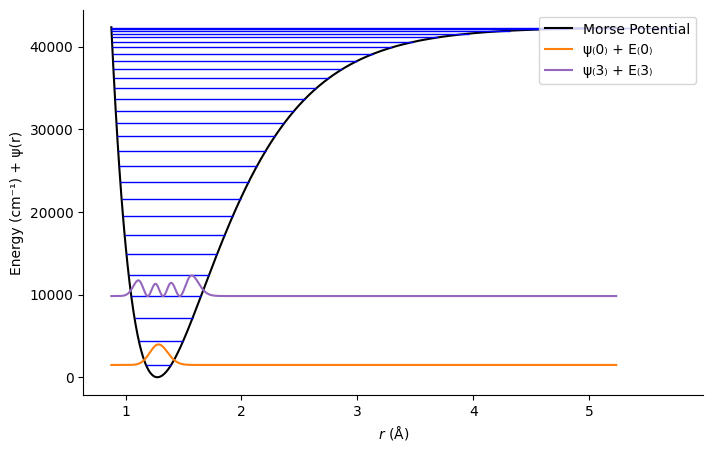

In [16]:
import numpy as np
from scipy.constants import h, hbar, c, u
from scipy.special import genlaguerre, gamma, factorial
import matplotlib.pyplot as plt

# Factor for conversion from cm⁻¹ to J
FAC = 100 * h * c

# ——— Utility Functions ———

def reduced_mass(mA, mB):
    """Return reduced mass (kg) for atoms of mass mA, mB in amu."""
    return mA * mB / (mA + mB) * u

def dissociation_energy(we, wexe):
    """Return De (J) from vibrational constants we, wexe in cm⁻¹."""
    return we**2 / (4 * wexe) * FAC

def morse_ke(we, mu):
    """Return effective spring constant ke (kg·s⁻²)."""
    return (2 * np.pi * c * 100 * we)**2 * mu

def morse_a(we, mu, De):
    """Return Morse parameter a (m⁻¹)."""
    return we * np.sqrt(2 * mu / De) * np.pi * c * 100

def morse_lambda(mu, De, a):
    """Return λ = sqrt(2µDe)/(aħ)."""
    return np.sqrt(2 * mu * De) / (a * hbar)

def vmax(lam):
    """Maximum bound-state quantum number."""
    return int(np.floor(lam - 0.5))

def make_rgrid(re, a, n=1000, f=0.999):
    """
    Build an r–grid (m) from rmin to rmax where V(rmin)=De and V(rmax)=f·De.
    Returns (r_array, dr).
    """
    rmin = re - np.log(2) / a
    rmax = re - np.log(1 - f) / a
    return np.linspace(rmin, rmax, n, retstep=True)

def morse_potential(r, De, a, re):
    """Morse potential V(r) in joules."""
    return De * (1 - np.exp(-a * (r - re)))**2

def energy_morse_J(v, we, wexe):
    """Morse oscillator level E_v in joules."""
    vp = v + 0.5
    return (we * vp - wexe * vp**2) * FAC

def turning_points(E, De, a, re):
    """Classical turning points (rm, rp) at energy E (J)."""
    b = np.sqrt(E / De)
    rm = re - np.log(1 + b) / a
    rp = re - np.log(1 - b) / a
    return rm, rp

def morse_wavefunction(v, r, lam, a, re, norm_peak=1.0):
    """
    Unnormalized Morse wavefunction ψ_v(r), scaled to `norm_peak`.
    Returns ψ(r).
    """
    z = 2 * lam * np.exp(-a * (r - re))
    alpha = 2 * (lam - v) - 1
    L = genlaguerre(v, alpha)
    psi = (z**(lam - v - 0.5) * np.exp(-z/2) * L(z))
    # scale to peak value norm_peak
    return psi * (norm_peak / np.max(np.abs(psi))) / 30

# ——— Example: CO molecule ———

# Input data
mA, mB    = 1.0, 35.0          # masses (amu)
we, wexe  = 2990.945, 52.818595 # vibrational constants (cm⁻¹)
re, Te    = 1.27455e-10, 0.0   # equilibrium bond length (m), electronic energy (arbitrary zero)

# Derived parameters
mu   = reduced_mass(mA, mB)
De   = dissociation_energy(we, wexe)
ke   = morse_ke(we, mu)
a    = morse_a(we, mu, De)
lam  = morse_lambda(mu, De, a)
vmax = vmax(lam)

# Build grid and compute potential
r, dr = make_rgrid(re, a)
V = morse_potential(r, De, a, re)

# ——— Plotting ———

fig, ax = plt.subplots(figsize=(8,5))

# Morse potential (converted back to cm⁻¹ for plotting + Te offset)
ax.plot(r*1e10, V/FAC + Te, color='black', label='Morse Potential')

# Energy levels and turning points
for v in range(vmax + 1):
    E = energy_morse_J(v, we, wexe)
    rm, rp = turning_points(E, De, a, re)
    ax.hlines(E/FAC + Te, rm*1e10, rp*1e10,
              colors='blue', linewidth=1)

# Plot two selected wavefunctions (v=0 and v=3)
for v, color in [(0, 'tab:orange'), (3, 'tab:purple')]:
    psi = morse_wavefunction(v, r, lam, a, re, norm_peak=we/2)
    psi_plot = psi ** 2 + energy_morse_J(v, we, wexe)/FAC + Te
    ax.plot(r*1e10, psi_plot, color=color, label=f'ψ₍{v}₎ + E₍{v}₎')

# Formatting
ax.set_xlabel(r'$r$ (Å)')
ax.set_ylabel(r'Energy (cm⁻¹) + ψ(r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')
plt.show()


### Reflection: Symmetry of the Vibrational Probability Density

Consider the probability density  
$$
|\psi_n(r)|^2
$$  
for the Morse‐oscillator eigenstates you just plotted.

1. **Symmetry Question:**  
   - Is the probability density $|\psi_n(r)|^2$ symmetric about the equilibrium bond length $r_{eq}$?  
   - How does this compare to the harmonic oscillator eigenstates you studied earlier?

2. **Physical Interpretation:**  
   - If the probability density is not perfectly symmetric, what physical feature of the Morse potential causes this asymmetry?  
   - How does anharmonicity influence the shape and location of the vibrational wavefunction peaks?

Take a moment to sketch or describe qualitatively what you expect for $|\psi_0(r)|^2$ and $|\psi_1(r)|^2$ in the Morse model, and compare with the harmonic oscillator case.  


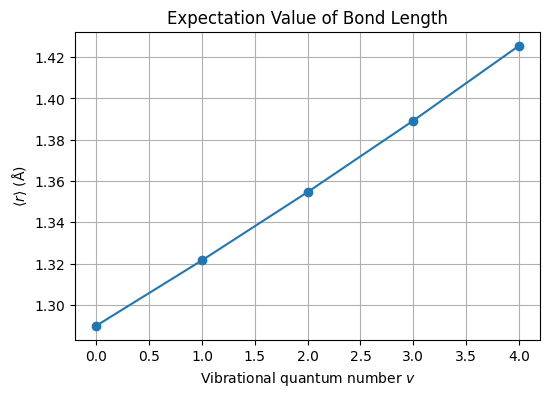

In [17]:
# ——— Expectation values ⟨r⟩ for v = 0…4 ———

states = range(5)
expectation_r = []

for v in states:
    # get the (unnormalized) wavefunction on the same grid
    psi = morse_wavefunction(v, r, lam, a, re)
    prob = psi**2

    # normalize
    norm = np.trapz(prob, r)
    prob_norm = prob / norm

    # compute ⟨r⟩
    exp_r = np.trapz(r * prob_norm, r)
    expectation_r.append(exp_r * 1e10)  # convert to Å

# ——— Plot ⟨r⟩ vs v ———

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(states, expectation_r, marker='o', linestyle='-')
ax.set_xlabel('Vibrational quantum number $v$')
ax.set_ylabel(r'$\langle r \rangle$ (Å)')
ax.set_title('Expectation Value of Bond Length')
ax.grid(True)
plt.show()


 re is 1.27455e-10


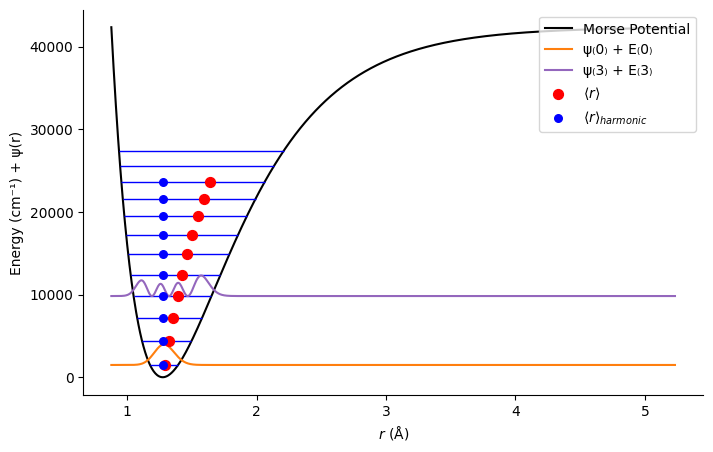

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Compute ⟨r⟩ and corresponding energies for v = 0…4
states = range(10)
expectation_r = []
harmonic_expectation_r = []
expectation_E = []
print(F" re is {re}")
for v in states:
    # get wavefunction on grid
    psi = morse_wavefunction(v, r, lam, a, re)
    prob = psi**2
    # normalize
    prob /= np.trapz(prob, r)
    # expectation ⟨r⟩ (convert to Å)
    exp_r = np.trapz(r * prob, r) * 1e10
    expectation_r.append(exp_r)
    # energy level in cm⁻¹ plus Te
    Ev = energy_morse_J(v, we, wexe) / FAC + Te
    expectation_E.append(Ev)
    harmonic_expectation_r.append(re * 1e10)

# Now plot everything
fig, ax = plt.subplots(figsize=(8,5))

# 1. Morse potential (black)
ax.plot(r*1e10, V/FAC + Te, color='black', label='Morse Potential')

# 2. Energy levels (blue lines)
for v in range(12):
    E = energy_morse_J(v, we, wexe)
    rm, rp = turning_points(E, De, a, re)
    ax.hlines(E/FAC + Te, rm*1e10, rp*1e10,
              colors='blue', linewidth=1)

# 3. Two example wavefunctions (v=0,3)
for v, color in [(0, 'tab:orange'), (3, 'tab:purple')]:
    psi = morse_wavefunction(v, r, lam, a, re, norm_peak=we/2)
    psi_plot = psi**2 + energy_morse_J(v, we, wexe)/FAC + Te
    ax.plot(r*1e10, psi_plot, color=color, label=f'ψ₍{v}₎ + E₍{v}₎')

# 4. Expectation values ⟨r⟩ as red dots
ax.scatter(expectation_r, expectation_E,
           color='red', s=50, zorder=5,
           label=r'$\langle r\rangle$')
ax.scatter(harmonic_expectation_r, expectation_E,
           color='blue', s=30, zorder=5,
           label=r'$\langle r\rangle_{harmonic}$')

# Formatting
ax.set_xlabel(r'$r$ (Å)')
ax.set_ylabel(r'Energy (cm⁻¹) + ψ(r)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='upper right')
plt.show()


## Reflection: Comparing ⟨r⟩ in Harmonic vs. Morse Oscillators

Take a moment to think about how the expectation value of the bond length, ⟨r⟩, changes as you go to higher vibrational states in each model.

1. **Harmonic Oscillator**  
   - What is the qualitative behavior of ⟨r⟩ as you increase the quantum number \(v\)?  
   - Why does a purely quadratic potential lead to that trend?

2. **Morse Oscillator**  
   - How does the anharmonicity of the Morse potential modify the growth of ⟨r⟩ with \(v\)?  
   - At high \(v\), how does ⟨r⟩ reflect the finite dissociation limit of the bond?

3. **Comparison & Implications**  
   - In which regime (low vs. high \(v\)) do the two models agree most closely, and why?  
   - How might differences in ⟨r⟩ affect predictions of spectroscopic transitions or bond dissociation?  

> _Use these questions to guide a short discussion or to prompt your own notes on the physical significance of ⟨r⟩ in anharmonic versus harmonic vibrational models._  
